In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report,f1_score,confusion_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)

# FUNCTIONS to check and remove outliers

#### 5 point summary fn

In [2]:
def five_point(column):
    print('5 point summary:')
    print(pd.DataFrame(column).describe().iloc[3:] )
    print('---------------------------------')

#### Z score fn

In [3]:
def z_score(column):
    
    mean=np.mean(column)
    stdev=np.std(column)
    
    with_z=pd.DataFrame( {
                            'outliers' : column,
                            'Z-score' : (column-mean)/stdev 
    })
    
    lower=-3*stdev+mean
    upper=3*stdev+mean
    
    print( 'OUTLIERS in '+column.name.upper()+' via Z score\n' )
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)
    print()
    
    outliers=with_z[ abs( with_z['Z-score'] )>3 ]          # observations with absolute value of z-score greater than 3 are considered outliers
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')

#### IQR fn

In [4]:
def IQR_method(column):
    
    print( 'OUTLIERS in '+column.name.upper()+' via IQR\n' )
    
    #extracting q1,q3 from df.describe
    q1,q3=column.describe().iloc[[4,6]]
    
    #upper and lower limit using iqr
    iqr=q3-q1
    upper=q3+1.5*iqr
    lower=q1-1.5*iqr
    
    print('Outlier limits:\nlower limit:',lower,'\nupper limit:',upper)            # outlier limits defined using quartiles, iqr and tukey value of 1.5
    print()
    
    outliers=pd.DataFrame( {
                            'outliers' : column[(column<lower) | (column>upper) ]
    })
    
    print('Total outliers:',len(outliers))
    print( outliers )
    print('---------------------------------')
    

#### Analysis of quantitative columns fn

In [5]:
def analysis_quant(column):
    print('\t\t\t\tANALYSIS OF:',column.name.upper(),'\n')

    five_point(column)      # five point summary
    z_score(column)         # z score and outliers
    IQR_method(column)      # iqr and outliers using boxplot
    
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,7),dpi=100)
    sns.boxplot(ax=axes[0] , x=column)                       # boxplot
    sns.histplot(ax=axes[1],data=column,bins=25)             # histogram
    plt.show()
    
    print('_____________________________________________________________________________________________________________________')

#### Analysis of categorical columns fn

In [6]:
def analysis_cate(column):    
    print('\t\t\t\tANALYSIS OF:',column.name.upper(),'\n')

    values=column.value_counts()
    print('No. of UNIQUE values:')
    print(values)
    print()

    fig, axes =  plt.subplots(1, 2, figsize=(25,5),dpi=100)

    # barplot
    sns.barplot(x=values.index, y=values, ax=axes[0])
    axes[0].set_ylabel('count')

    # pie chart
    axes[1].pie(x=values, labels=values.index )
    plt.show()
    
    print('_____________________________________________________________________________________________________________________')

#### Remove outliers fn

In [7]:
def remove_outliers(df,column,using='IQR'):
    
    '''Remove outliers from dataframe by using either IQR or Z
       Parameters: df: a pandas dataframe
                   column: column(name) from which outliers are to be removed
                   using: by default 'IQR' is used. Other option is 'Z'
    '''
    
    if using.upper()=='IQR':
        
        #extracting q1,q3 from df.describe
        q1,q3=df[column].describe().iloc[[4,6]]

        #upper and lower limit using iqr
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        
        outliers=pd.DataFrame( { 'outliers' : df[column][(df[column]<lower) | (df[column]>upper)] } )
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)
        
        
    if using.upper()=='Z':
        
        mean=np.mean(df[column])
        stdev=np.std(df[column])

        with_z=pd.DataFrame( {'outliers' : df[column], 'Z-score' : (df[column]-mean)/stdev  })

        lower=-3*stdev+mean
        upper=3*stdev+mean

        outliers=with_z[ abs( with_z['Z-score'] )>3 ]
        df.drop(index=outliers.index, inplace=True)
        print('Removed the following outliers:\n',outliers)


#### Compress outliers fn

In [8]:
def compress_outliers(df,column,using='IQR'):
    
    '''Compress outliers from dataframe into extreme ends of the data by using either IQR or Z
       Parameters: df: a pandas dataframe
                   column: column(name) from which outliers are to be removed
                   using: by default 'IQR' is used. Other option is 'Z'
    '''
    
    if using.upper()=='IQR':
        
        #extracting q1,q3 from df.describe
        q1,q3=df[column].describe().iloc[[4,6]]

        #upper and lower limit using iqr
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        
        outliers=pd.DataFrame( { 'outliers' : df[column][(df[column]<lower) | (df[column]>upper)] } )
        df.loc[ df[column] > upper, column] = upper
        df.loc[ df[column] < lower, column] = lower
        print('Compressed the following outliers:\n',outliers)
        
        
    if using.upper()=='Z':
        
        mean=np.mean(df[column])
        stdev=np.std(df[column])

        with_z=pd.DataFrame( {'outliers' : df[column], 'Z-score' : (df[column]-mean)/stdev  })

        lower=-3*stdev+mean
        upper=3*stdev+mean

        outliers=with_z[ abs( with_z['Z-score'] )>3 ]
        df.loc[ df[column] > upper, column] = upper
        df.loc[ df[column] < lower, column] = lower
        print('Compressed the following outliers:\n',outliers)


# plot correlation fn

In [9]:
def correlation(df):
    fig , ax= plt.subplots(1,2, figsize=(20,10), dpi=150)

    pearson=df.corr()
    ax[0].set_title('pearson')
    sns.heatmap(pearson, cmap='YlGnBu', square=True, annot=True, ax=ax[0])

    spearman=df.corr(method='spearman')
    ax[1].set_title('spearman')
    sns.heatmap(spearman, cmap='YlGnBu', square=True, annot=True, ax=ax[1])

    plt.show()

# About dataset

### loading dataset

In [10]:
list1=['4th period', '3rd period', '2nd period', '1st period', 'all period', 'Time frame']
df_dict={}

In [11]:
for i in list1:
    df_dict[i]= pd.read_excel('stock_portfolio_performance.xlsx', skiprows=[0], sheet_name=i)

### Time frame

In [12]:
df_time_frame=df_dict['Time frame']
df_time_frame.head()

,The all-period,1990/9/30,2010/6/30,80 quarters (20 years)
0,The 1st period,1990/9/30,1995/6/30,20 quarters (5 years)
1,The 2nd period,1995/9/30,2000/6/30,20 quarters (5 years)
2,The 3rd period,2000/9/30,2005/6/30,20 quarters (5 years)
3,The 4th period,2005/9/30,2010/6/30,20 quarters (5 years)


### Data dictionary

In [13]:
all_columns=['Large B/P',
             'Large ROE',
             'Large S/P',
             'Large Return Rate in the last quarter',
             'Large Market Value',
             'Small systematic Risk',
             'Annual Return',
             'Excess Return',
             'Systematic Risk',
             'Total Risk',
             'Abs. Win Rate',
             'Rel. Win Rate'
]

description=['Book value to price , Total assets − Total liabilities',
             'Return on equity, roe=net income/avg shareholders equity',
             'The price-to-sales ratio, valuation ratio that compares a company’s stock price to its revenues',
             'net gain or loss of an investment over a specified time period',
             'price an asset would fetch in the marketplace',
             'refers to the risk inherent to the entire market or market segment',
             'the return that an investment provides over a period of time',
             'used to denote how a fund has performed compared to a benchmark',
             'Original systematic risk',
             "Risk is defined in financial terms as the chance that an outcome or investment's actual gains will differ from an expected outcome or return",
             'Absolute Win Rate, refers to the rate at which a sales team turns opportunities into customers',
             'Relative win rate',
]

dict1={'Feature':all_columns,
       'Description':description,
      }

data_dict=pd.DataFrame(dict1)

data_dict

,Feature,Description
0,Large B/P,"Book value to price , Total assets − Total lia..."
1,Large ROE,"Return on equity, roe=net income/avg sharehold..."
2,Large S/P,"The price-to-sales ratio, valuation ratio that..."
3,Large Return Rate in the last quarter,net gain or loss of an investment over a speci...
4,Large Market Value,price an asset would fetch in the marketplace
5,Small systematic Risk,refers to the risk inherent to the entire mark...
6,Annual Return,the return that an investment provides over a ...
7,Excess Return,used to denote how a fund has performed compar...
8,Systematic Risk,Original systematic risk
9,Total Risk,Risk is defined in financial terms as the chan...


### all period analysis

In [14]:
df_all=df_dict['all period'].iloc[:,:13].set_index('ID', drop=True)
df_all.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.139,0.010,1.33,0.149,0.663,0.525
2,0.0,1.0,0.0,0.0,0.0,0.0,0.143,0.010,1.17,0.108,0.663,0.650
3,0.0,0.0,1.0,0.0,0.0,0.0,0.173,0.018,1.30,0.144,0.638,0.513
4,0.0,0.0,0.0,1.0,0.0,0.0,0.096,-0.002,1.39,0.144,0.613,0.475
5,0.0,0.0,0.0,0.0,1.0,0.0,0.096,0.001,1.04,0.087,0.725,0.538


In [15]:
list(df_all.columns)

[' Large B/P ',
 ' Large ROE ',
 ' Large S/P ',
 ' Large Return Rate in the last quarter ',
 ' Large Market Value ',
 ' Small systematic Risk',
 'Annual Return',
 'Excess Return',
 'Systematic Risk',
 'Total Risk',
 'Abs. Win Rate',
 'Rel. Win Rate']

[]

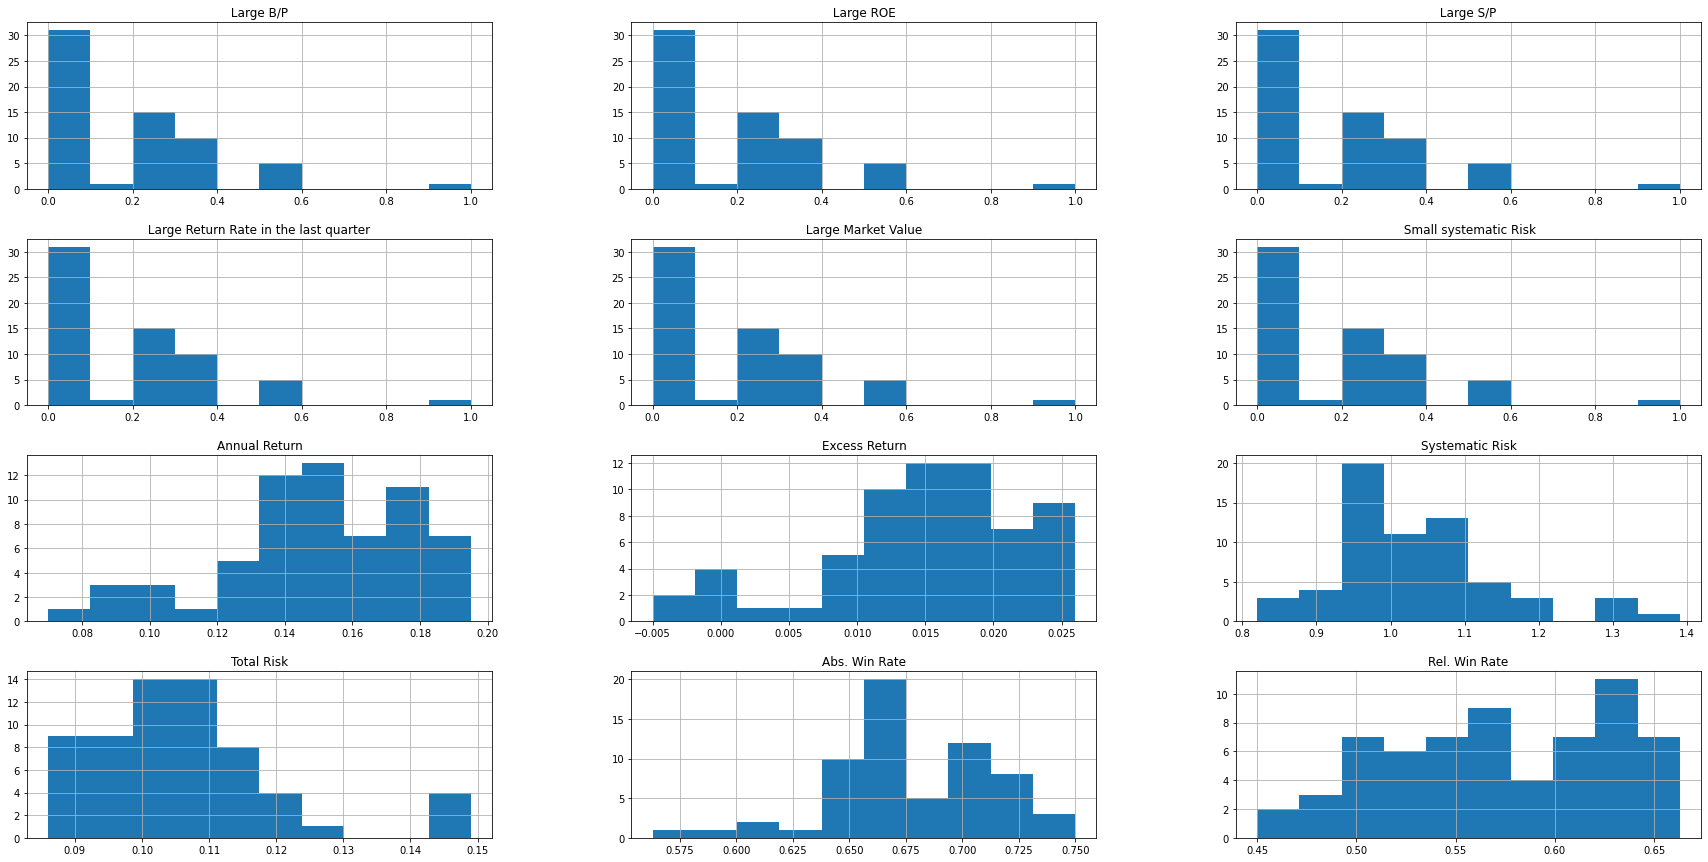

In [16]:
df_all.hist(figsize=(30,15))
plt.plot()

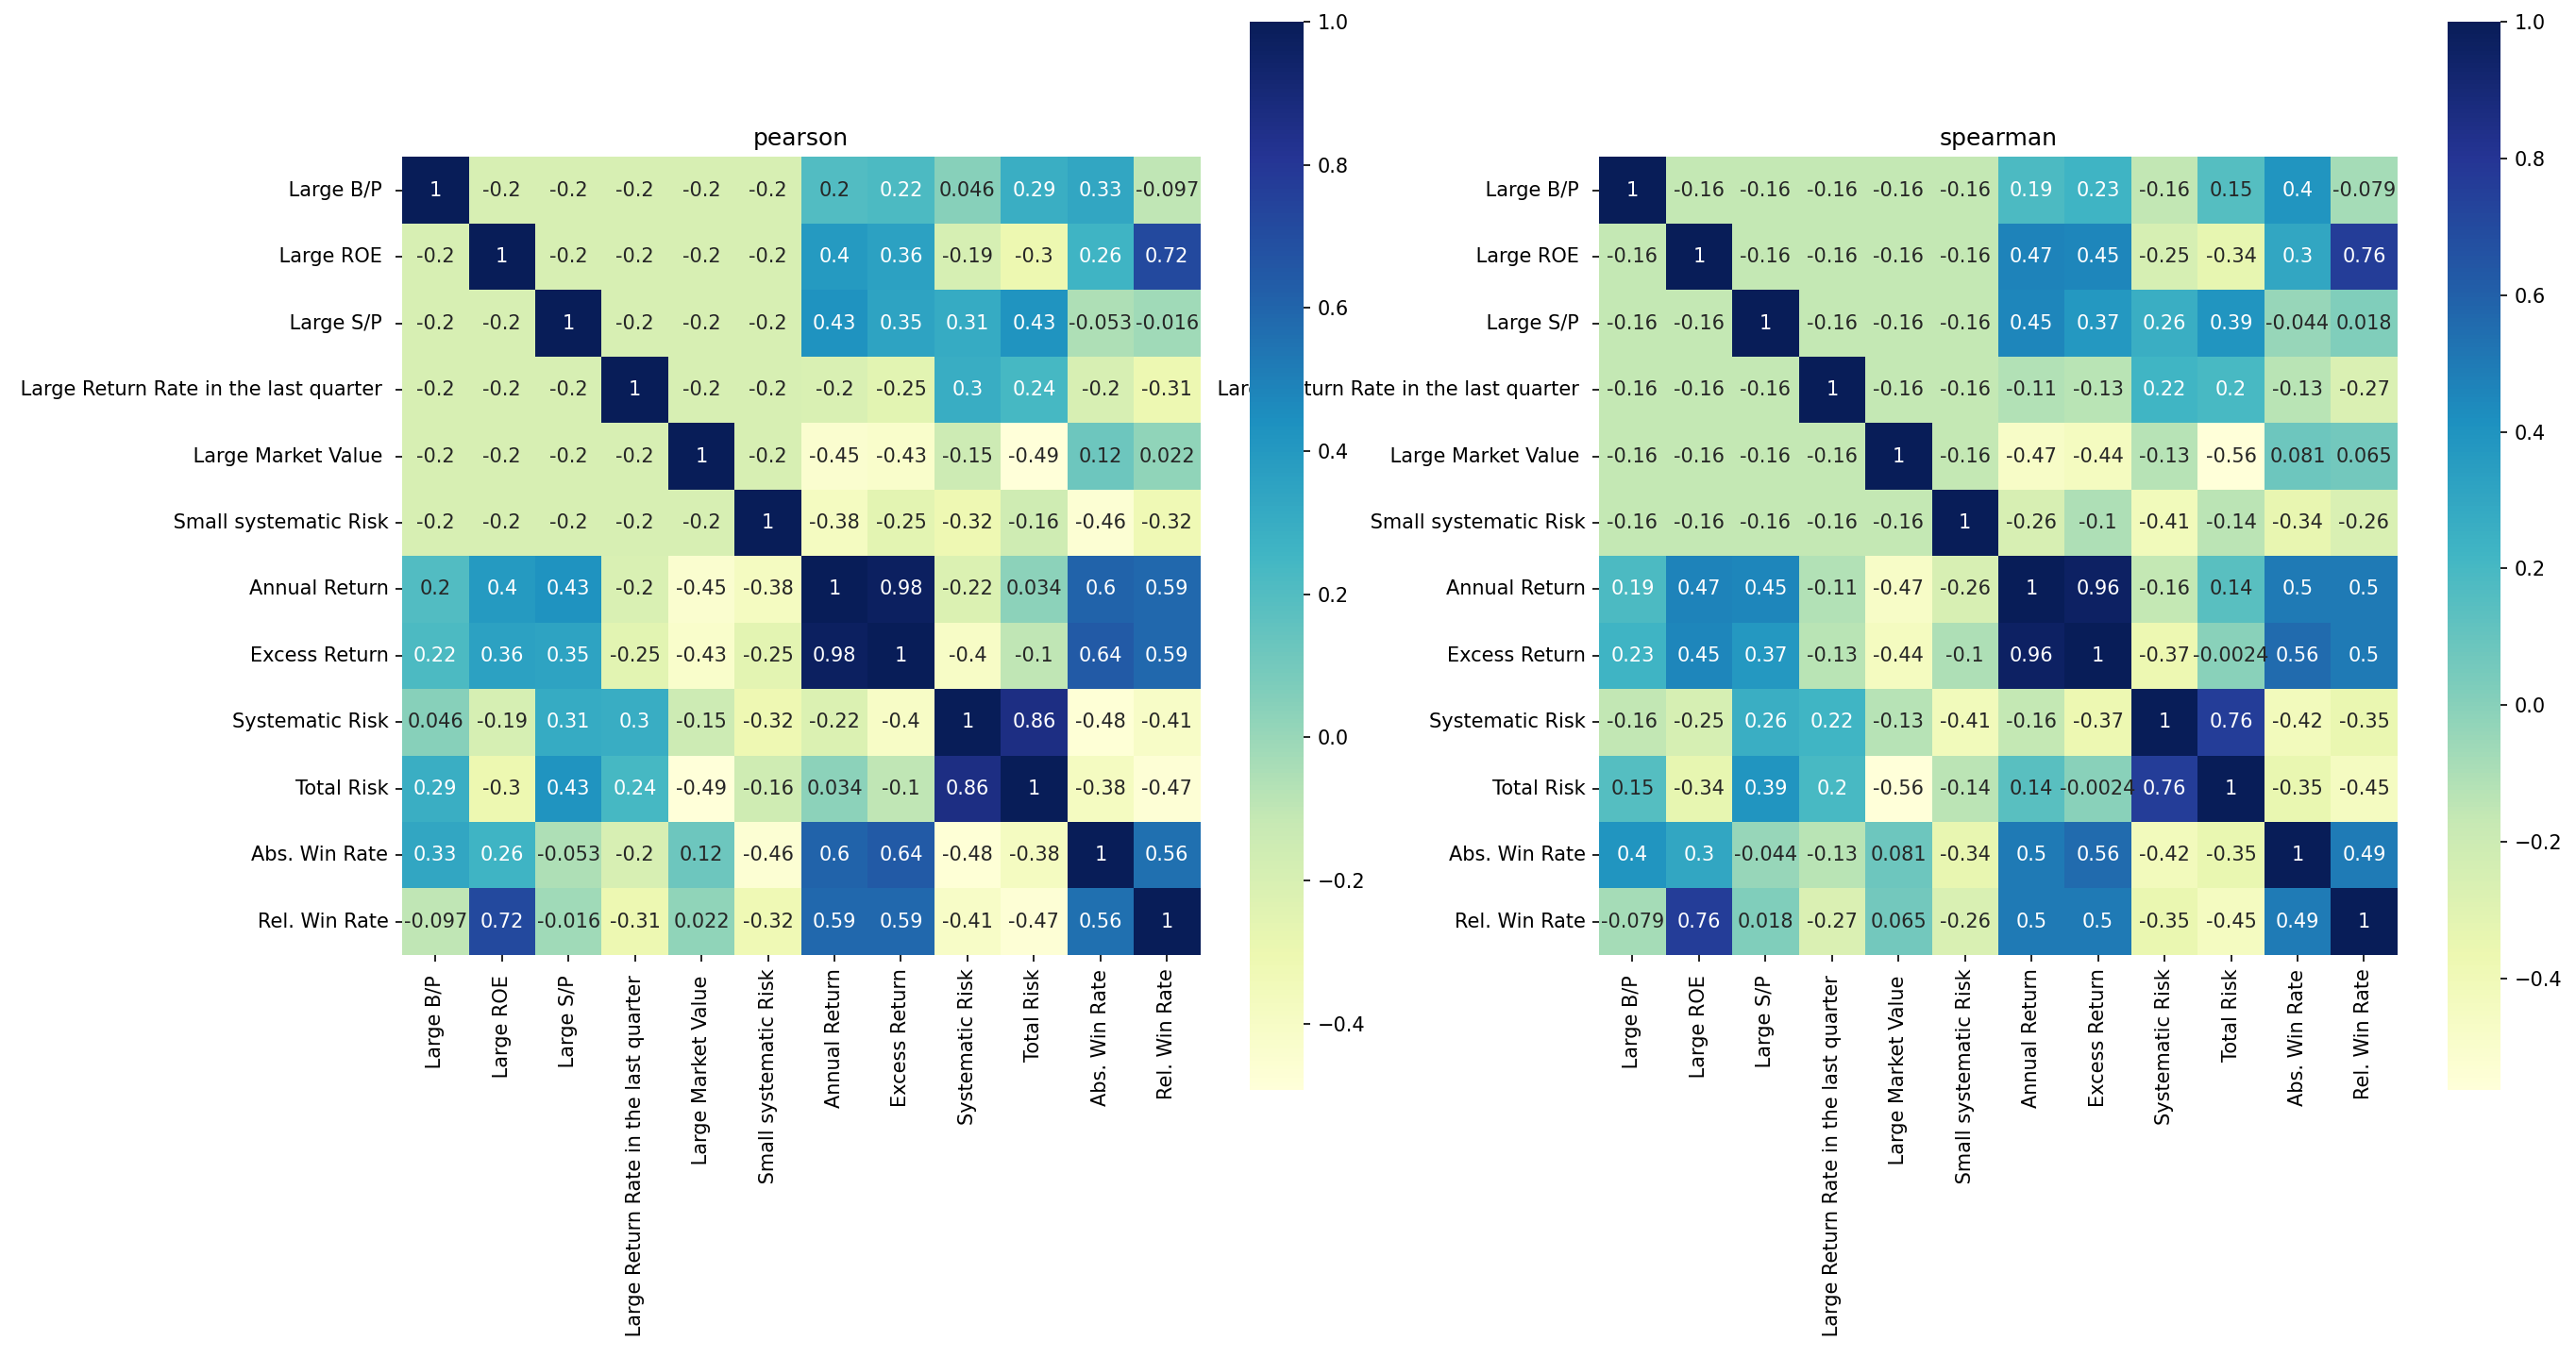

In [17]:
correlation(df_all)

### 1st period analysis

In [18]:
df_1=df_dict['1st period'].iloc[:,:13].set_index('ID', drop=True)
df_1.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.255357,0.020778,0.975575,0.081426,0.80,0.60
2,0.0,1.0,0.0,0.0,0.0,0.0,0.249602,0.003960,1.350801,0.077498,0.85,0.75
3,0.0,0.0,1.0,0.0,0.0,0.0,0.231246,0.013456,1.040006,0.087826,0.80,0.40
4,0.0,0.0,0.0,1.0,0.0,0.0,0.203809,-0.002600,1.291899,0.088624,0.70,0.60
5,0.0,0.0,0.0,0.0,1.0,0.0,0.163830,-0.000795,0.974706,0.046071,0.80,0.45


[]

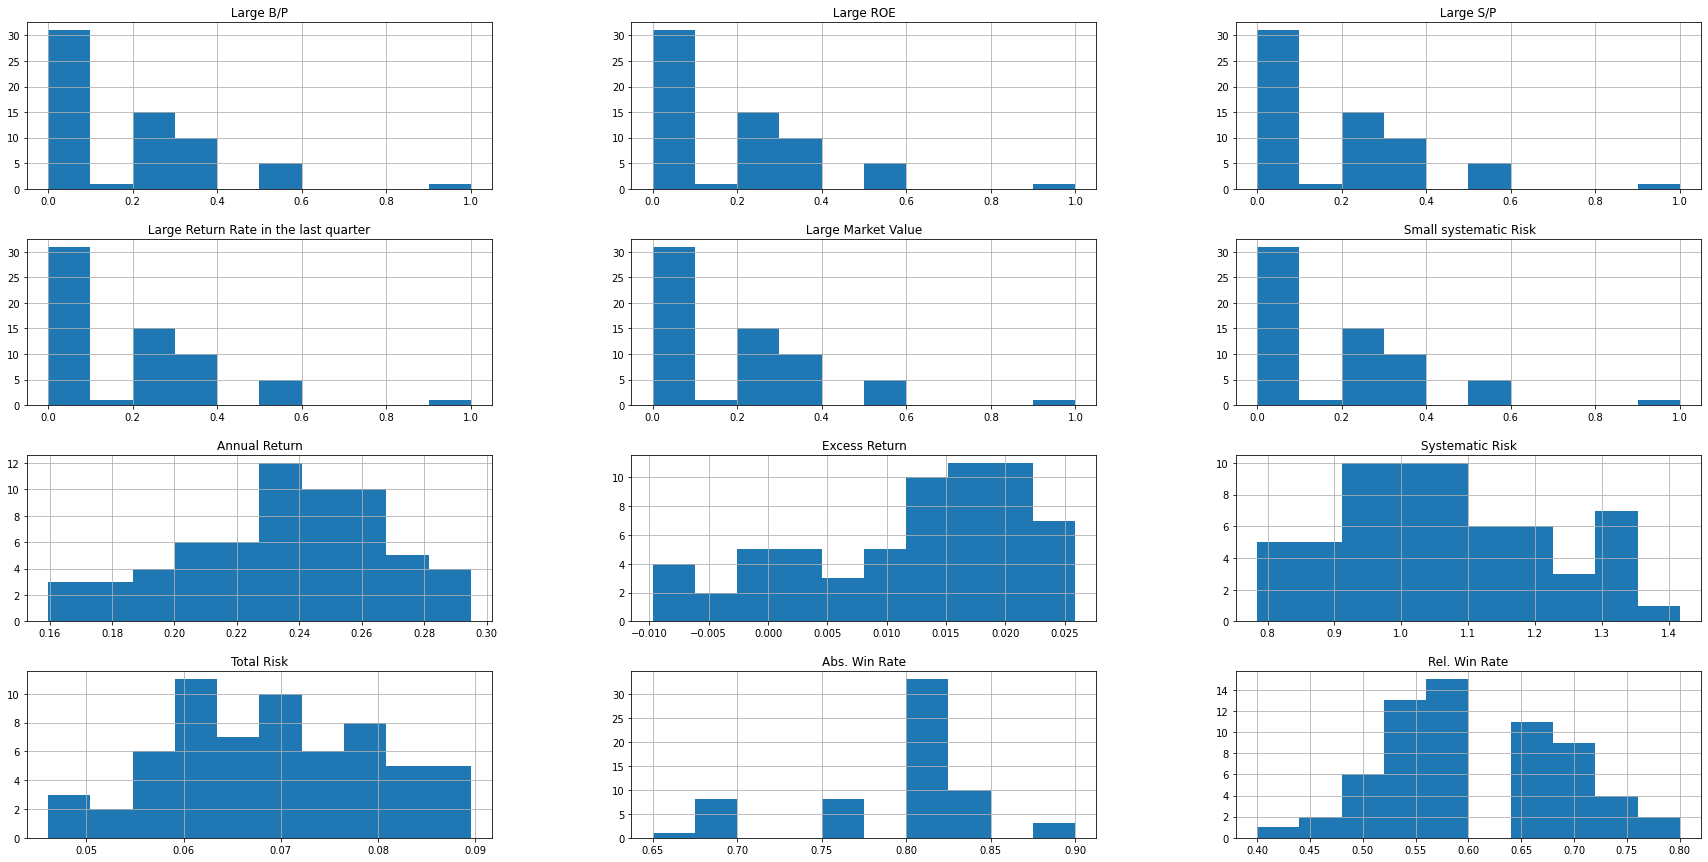

In [19]:
df_1.hist(figsize=(30,15))
plt.plot()

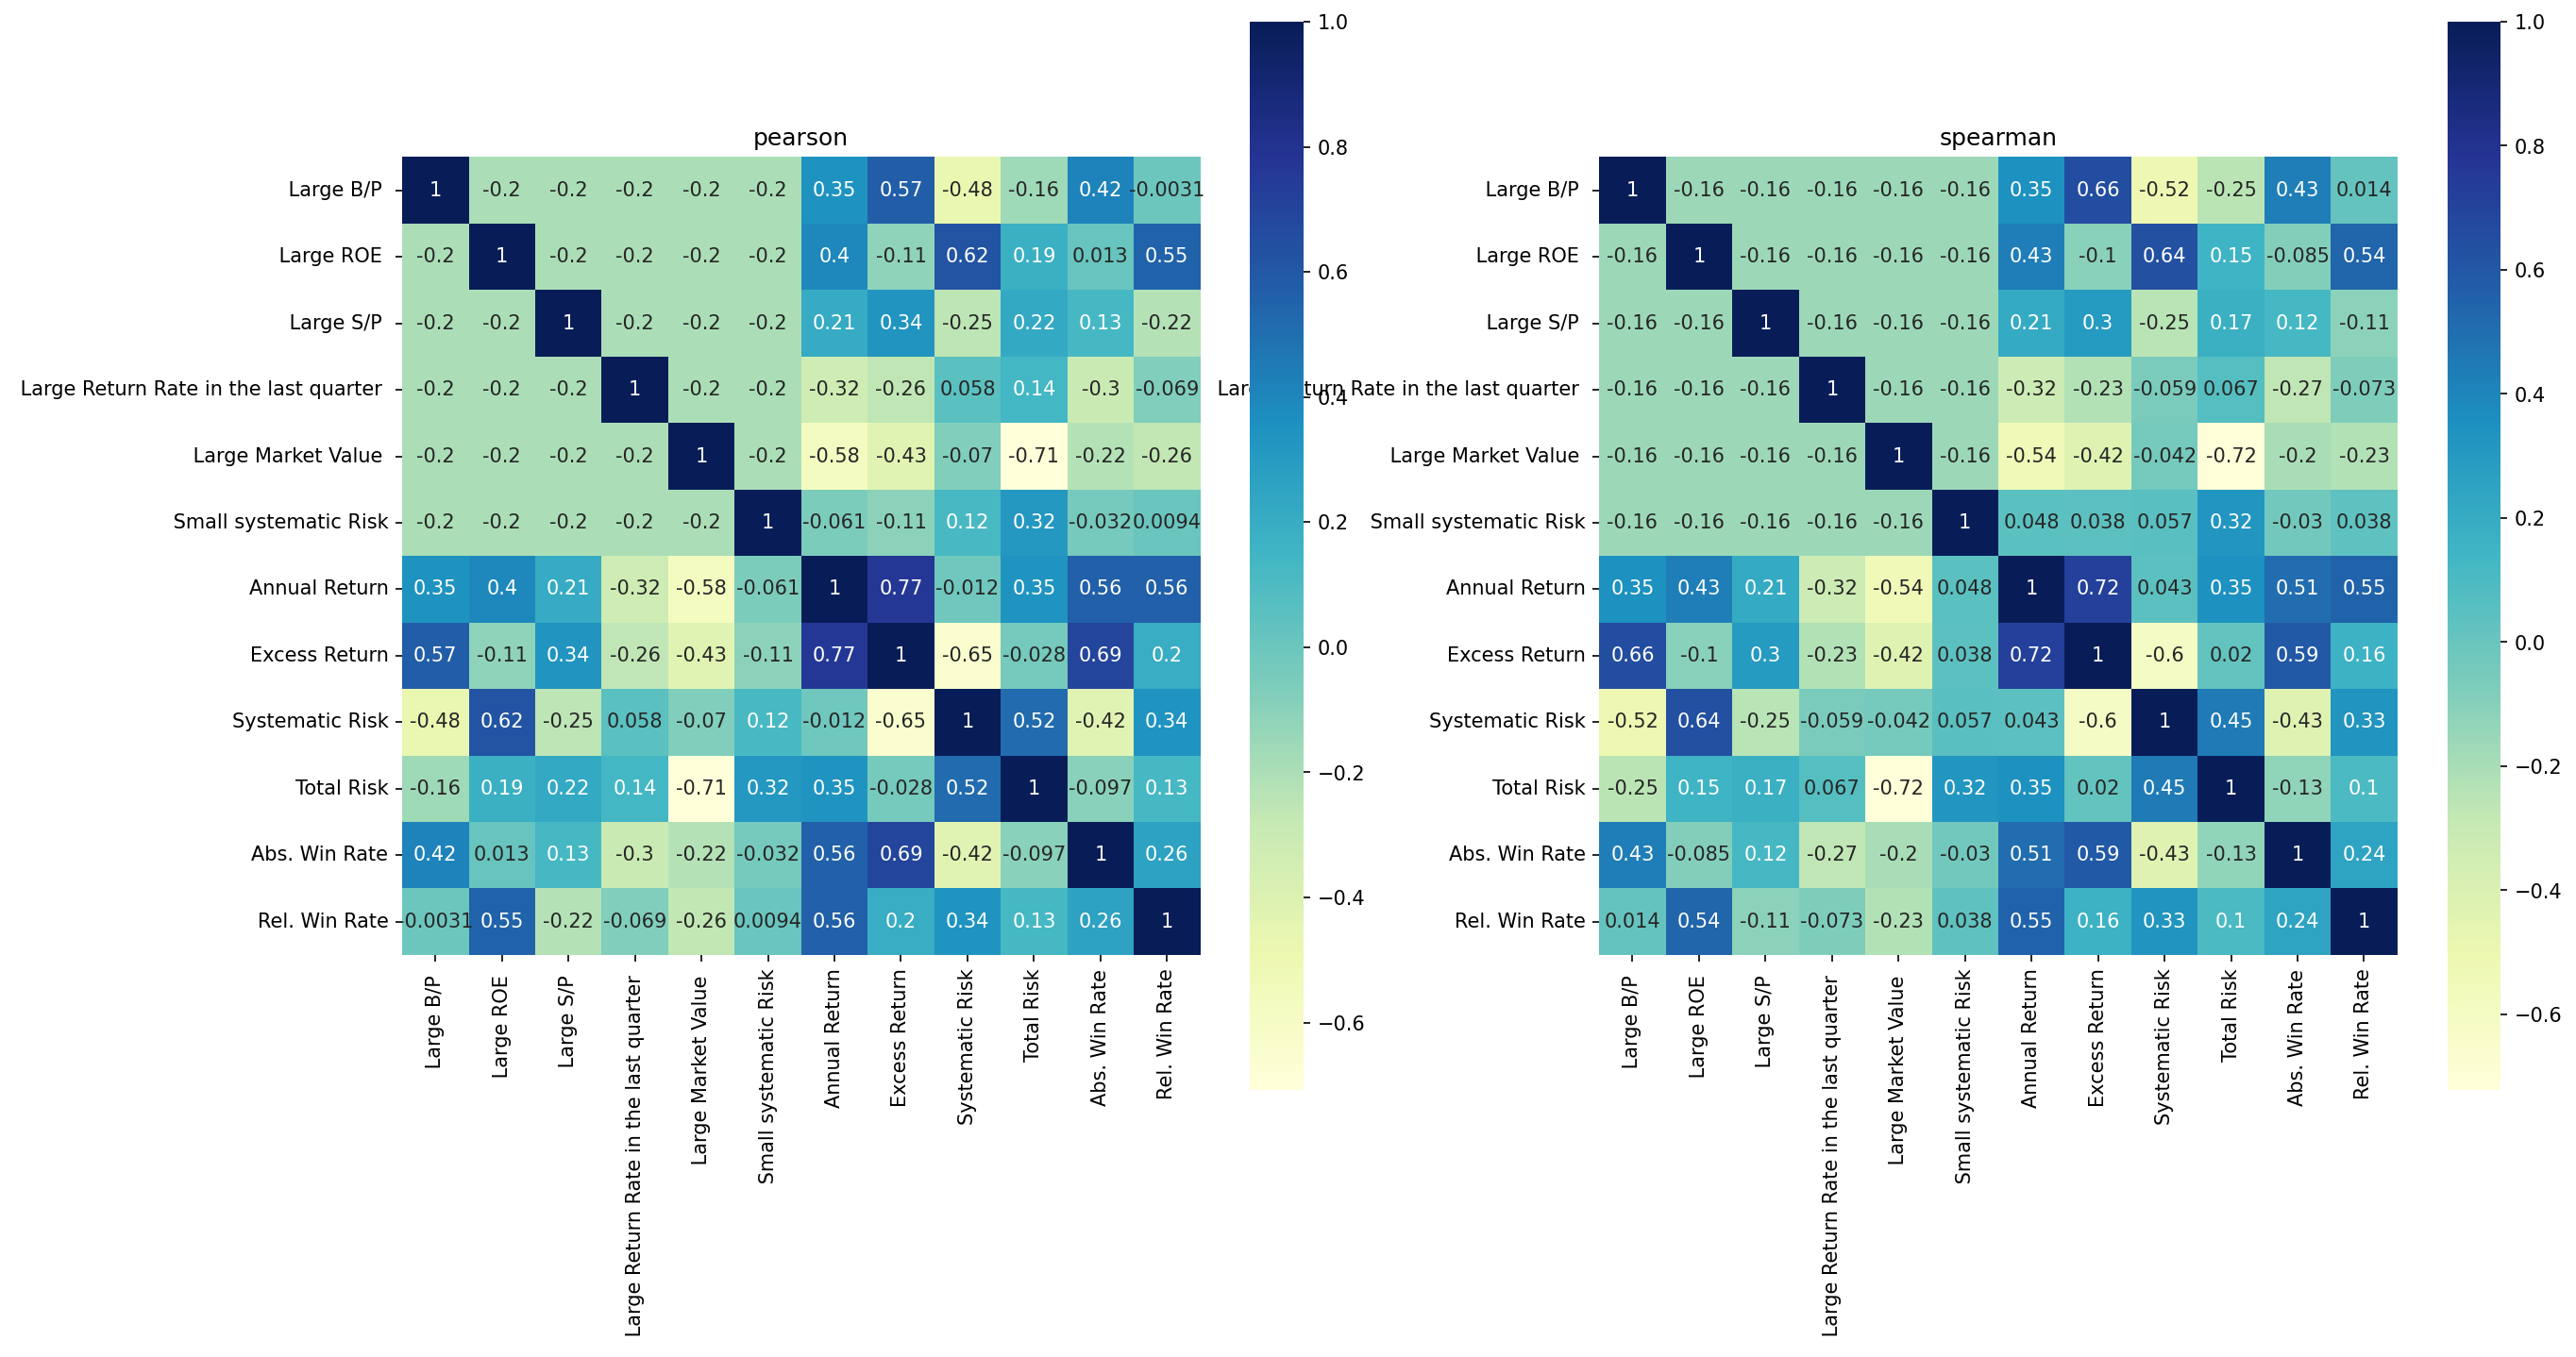

In [20]:
correlation(df_1)

### 2nd period analysis

In [21]:
df_2=df_dict['2nd period'].iloc[:,:13].set_index('ID', drop=True)
df_2.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.077004,-0.015932,0.736939,0.095878,0.60,0.30
2,0.0,1.0,0.0,0.0,0.0,0.0,0.167495,-0.017357,1.169841,0.103008,0.70,0.40
3,0.0,0.0,1.0,0.0,0.0,0.0,0.097648,-0.025967,1.049221,0.111338,0.55,0.30
4,0.0,0.0,0.0,1.0,0.0,0.0,0.203422,-0.016849,1.438916,0.164251,0.70,0.40
5,0.0,0.0,0.0,0.0,1.0,0.0,0.178471,-0.008925,1.016983,0.079385,0.85,0.25


[]

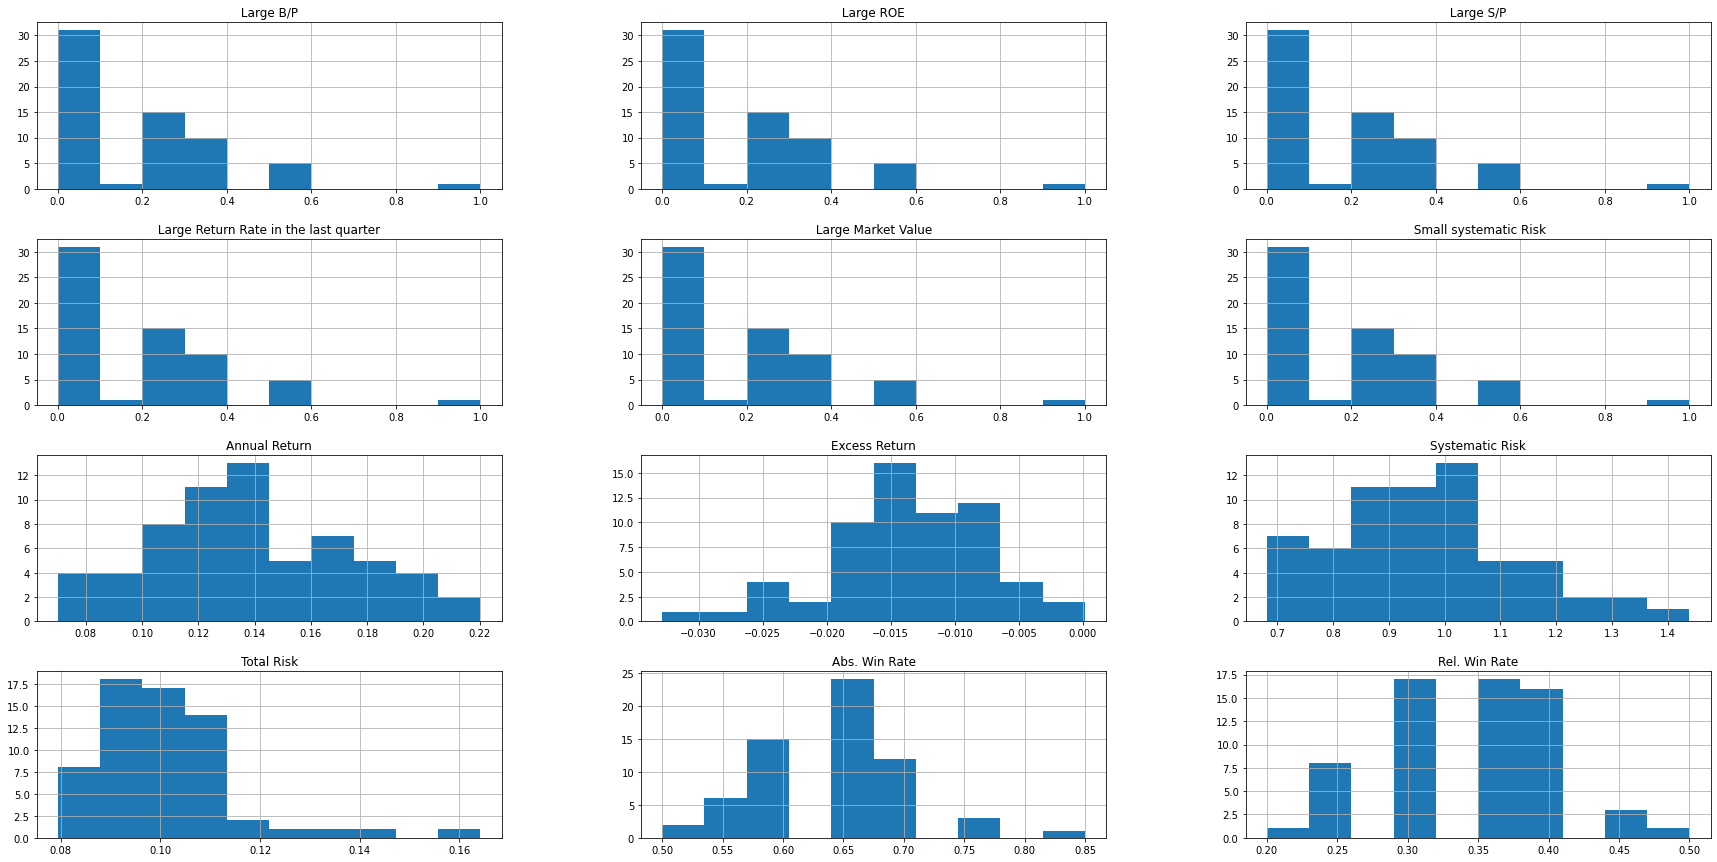

In [22]:
df_2.hist(figsize=(30,15))
plt.plot()

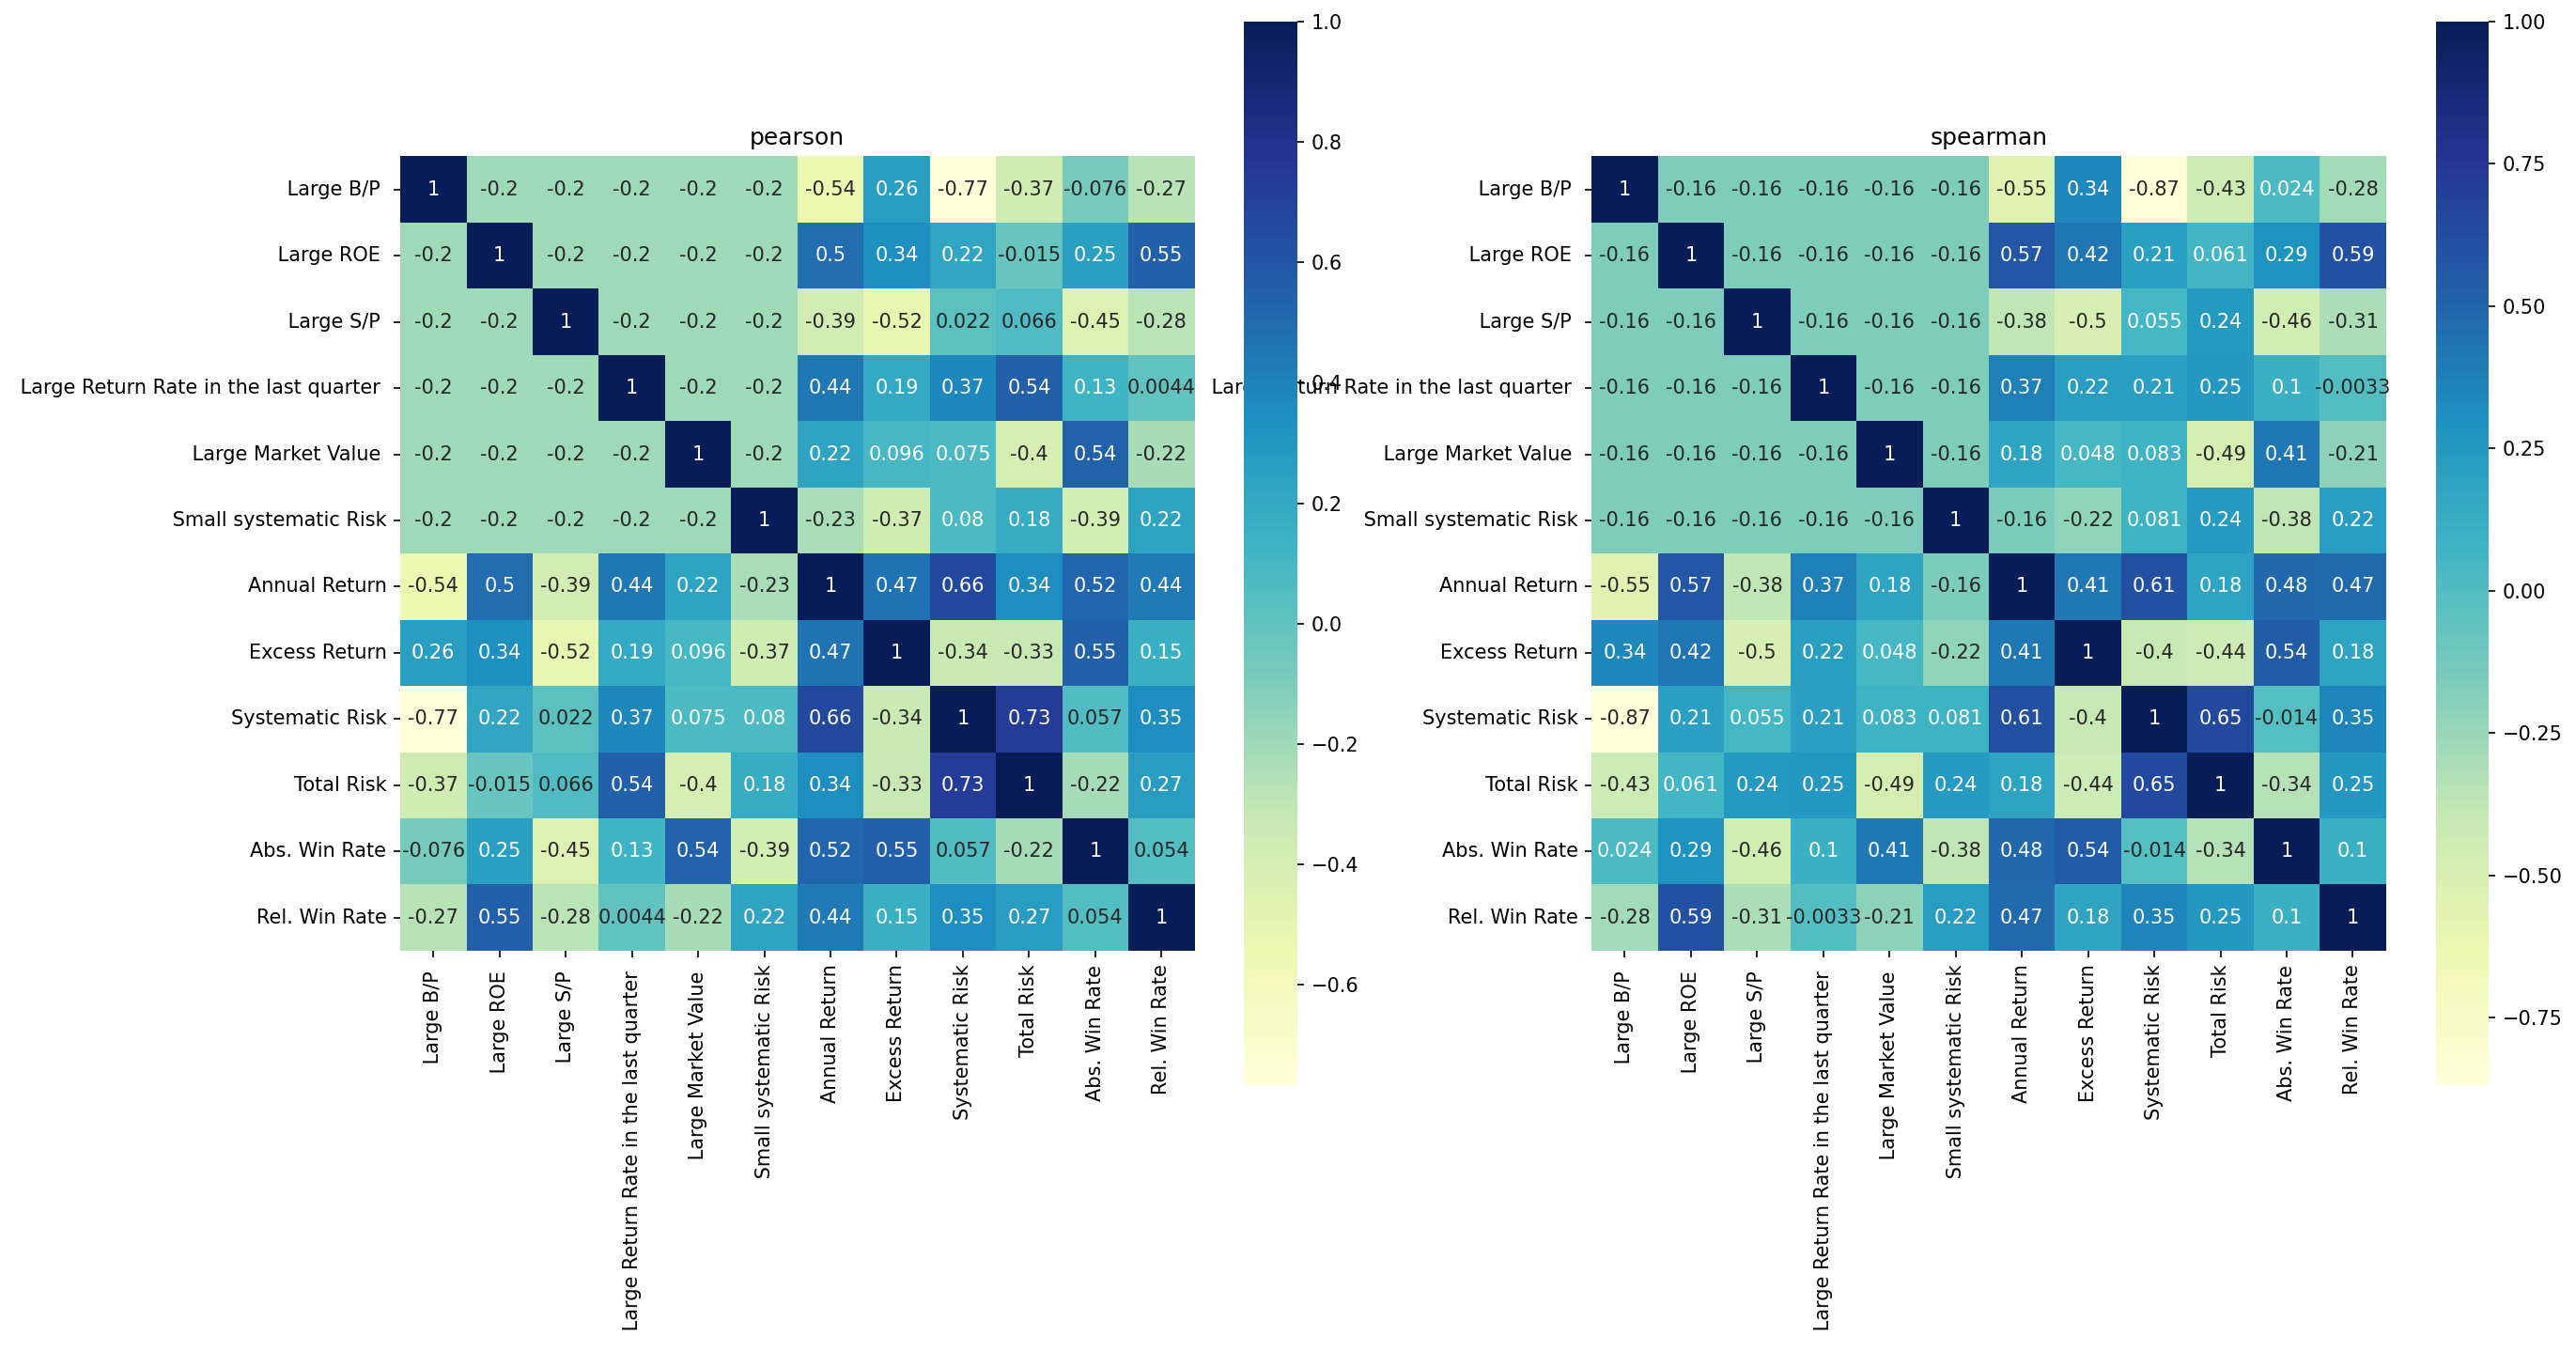

In [23]:
correlation(df_2)

### 3rd period analysis

In [24]:
df_3=df_dict['3rd period'].iloc[:,:13].set_index('ID', drop=True)
df_3.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.221805,0.062884,1.580440,0.164360,0.65,0.80
2,0.0,1.0,0.0,0.0,0.0,0.0,0.142353,0.039906,1.207561,0.120847,0.55,0.80
3,0.0,0.0,1.0,0.0,0.0,0.0,0.295726,0.076156,1.316862,0.147754,0.65,0.85
4,0.0,0.0,0.0,1.0,0.0,0.0,0.002086,0.012470,1.437964,0.159745,0.50,0.55
5,0.0,0.0,0.0,0.0,1.0,0.0,0.030526,0.012328,1.109287,0.104520,0.60,0.75


[]

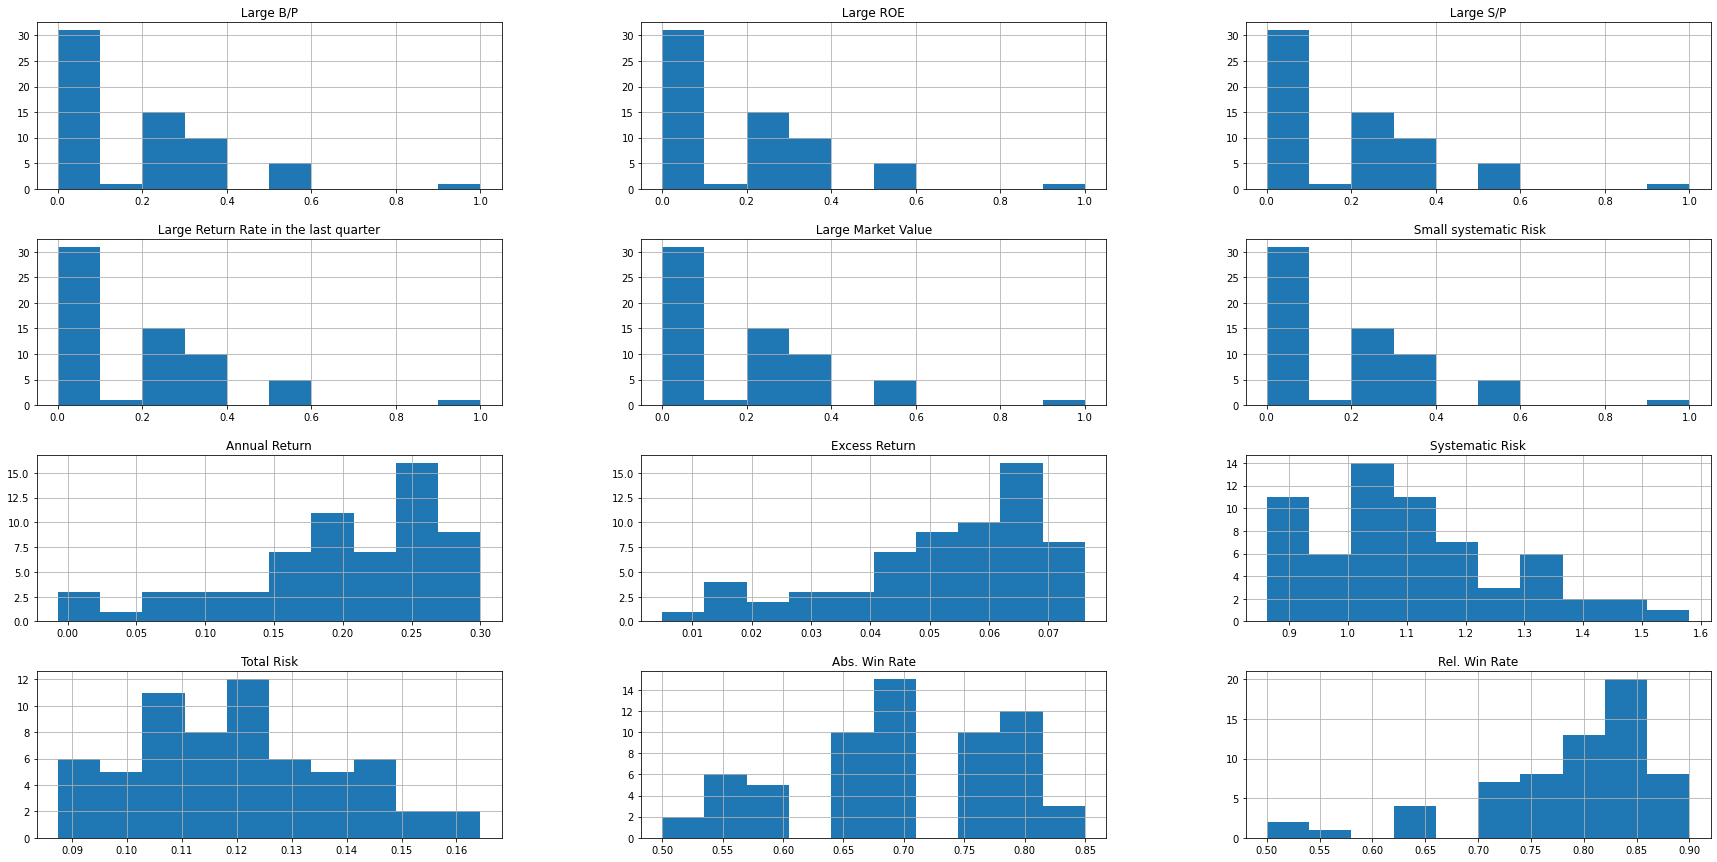

In [25]:
df_3.hist(figsize=(30,15))
plt.plot()

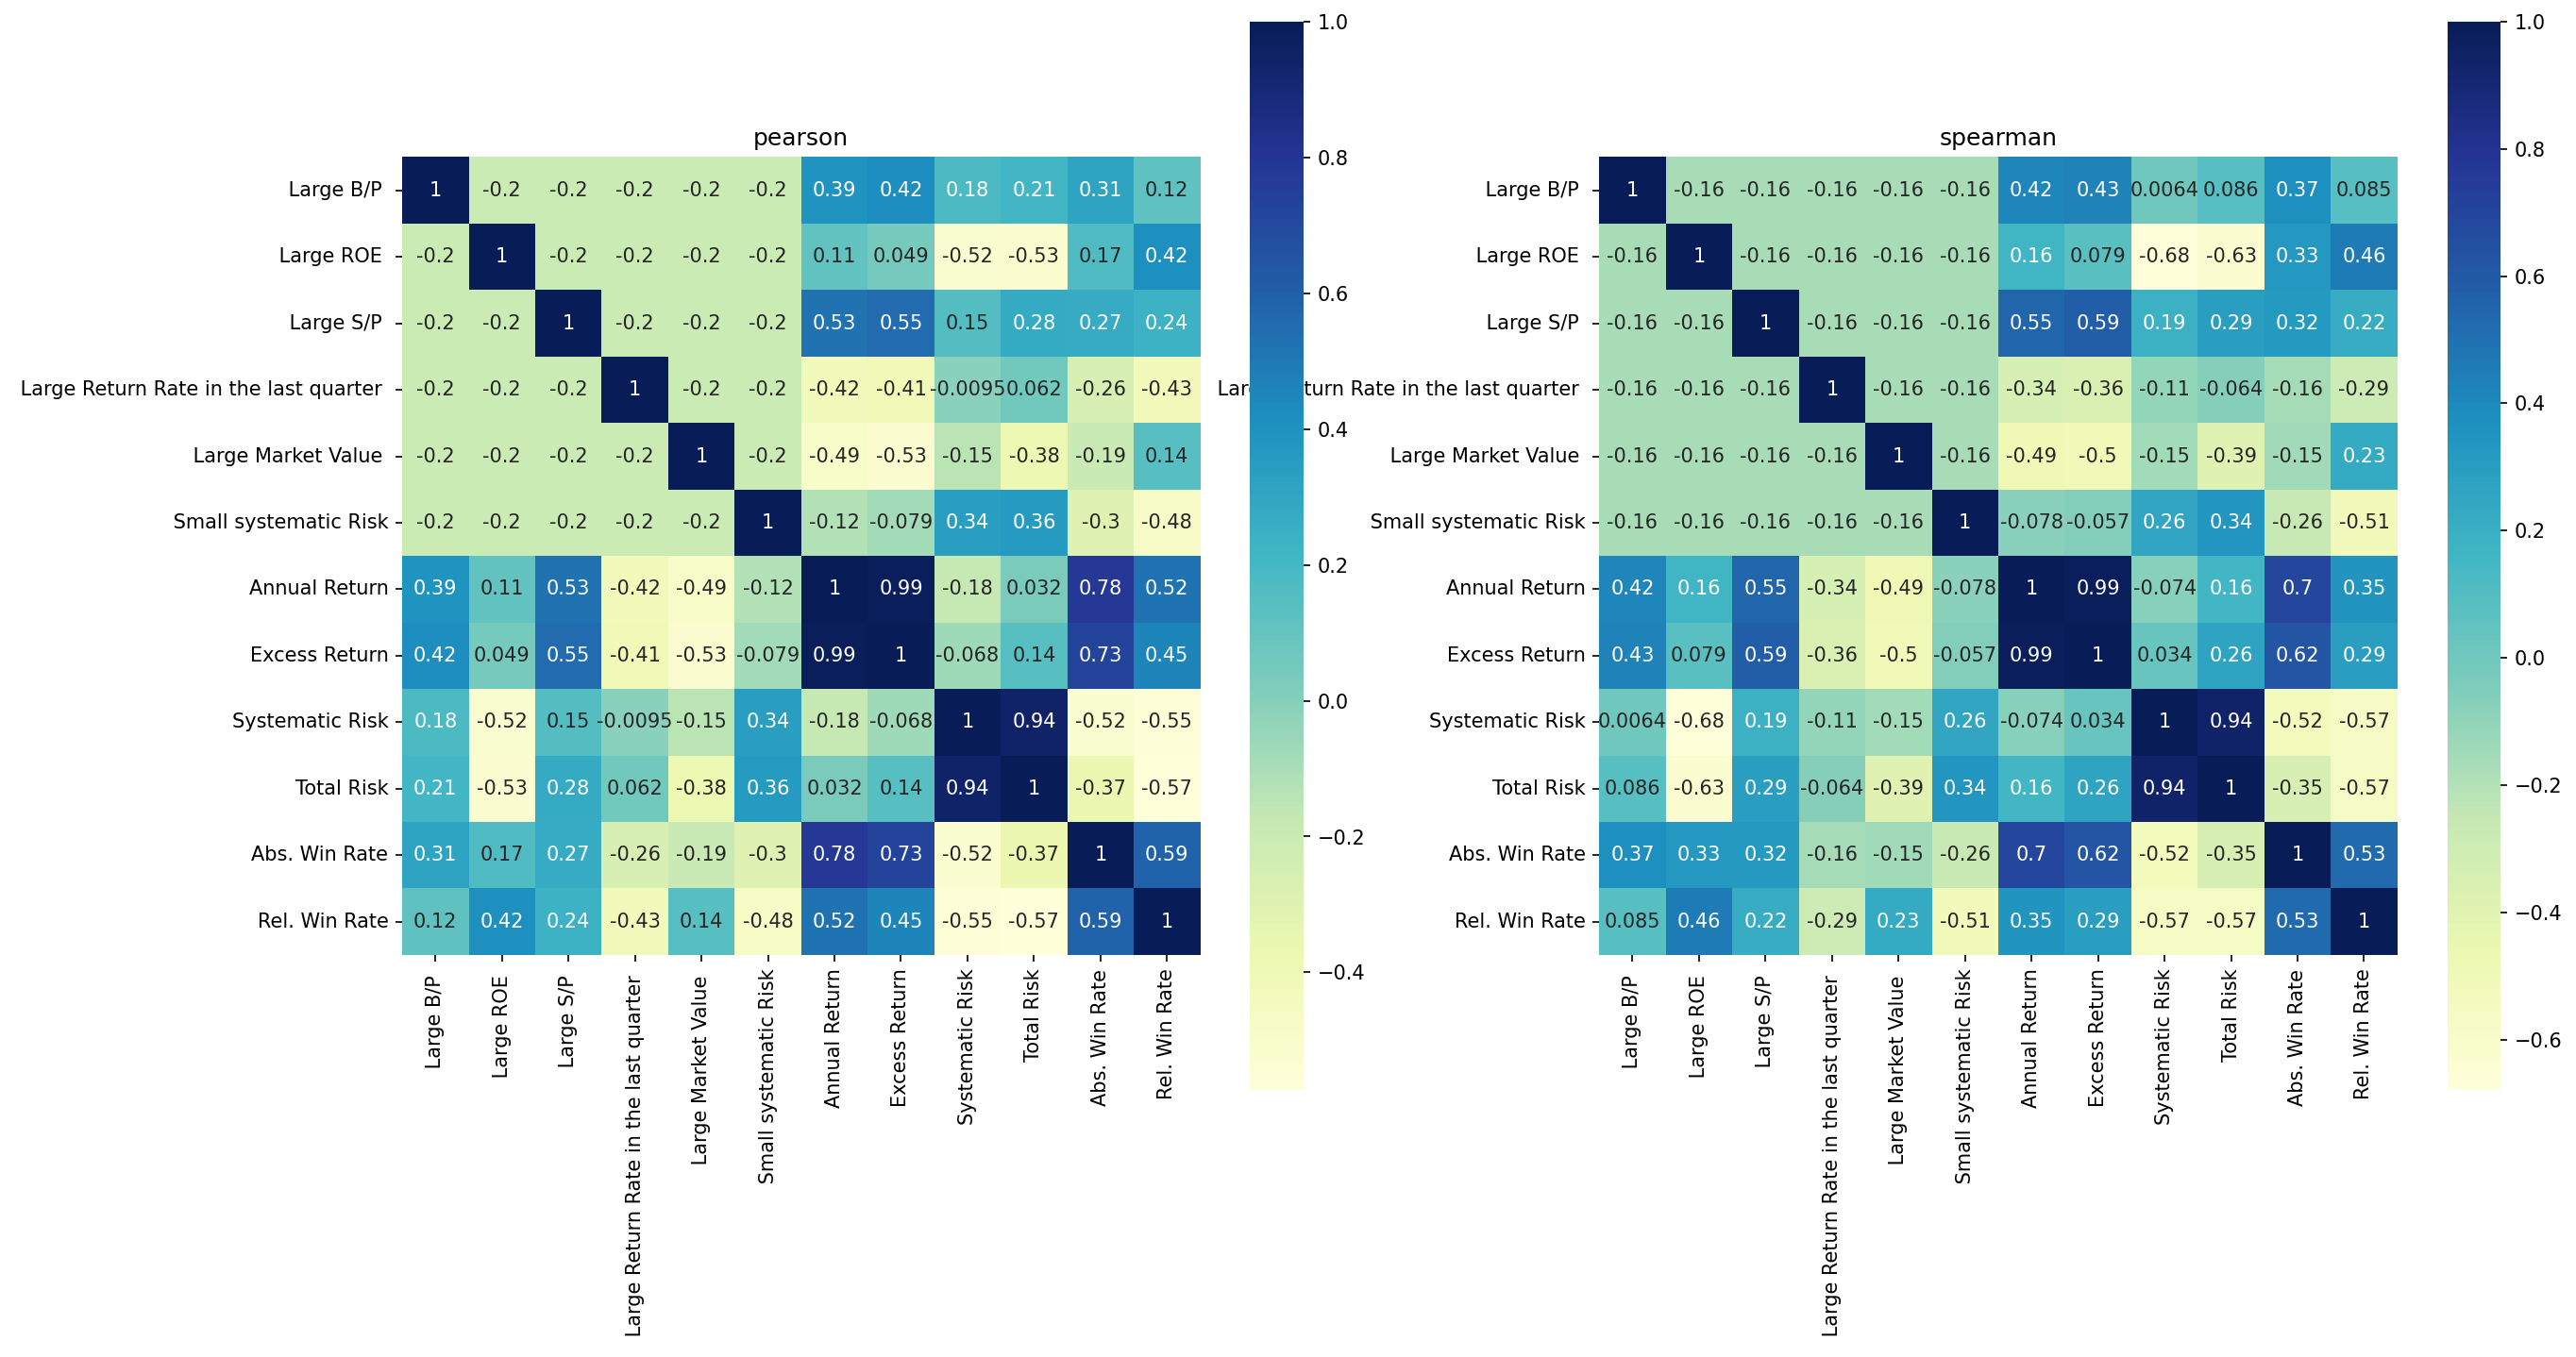

In [26]:
correlation(df_3)

### 4th period analysis

In [27]:
df_4=df_dict['4th period'].iloc[:,:13].set_index('ID', drop=True)
df_4.head()

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Annual Return,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.019516,0.013399,1.902608,0.218617,0.60,0.40
2,0.0,1.0,0.0,0.0,0.0,0.0,0.023829,0.006410,1.263287,0.128740,0.55,0.65
3,0.0,0.0,1.0,0.0,0.0,0.0,0.080282,0.026548,1.894339,0.208272,0.55,0.50
4,0.0,0.0,0.0,1.0,0.0,0.0,-0.006683,0.000728,1.425454,0.155526,0.55,0.35
5,0.0,0.0,0.0,0.0,1.0,0.0,0.021999,0.004407,1.094579,0.106729,0.65,0.70


[]

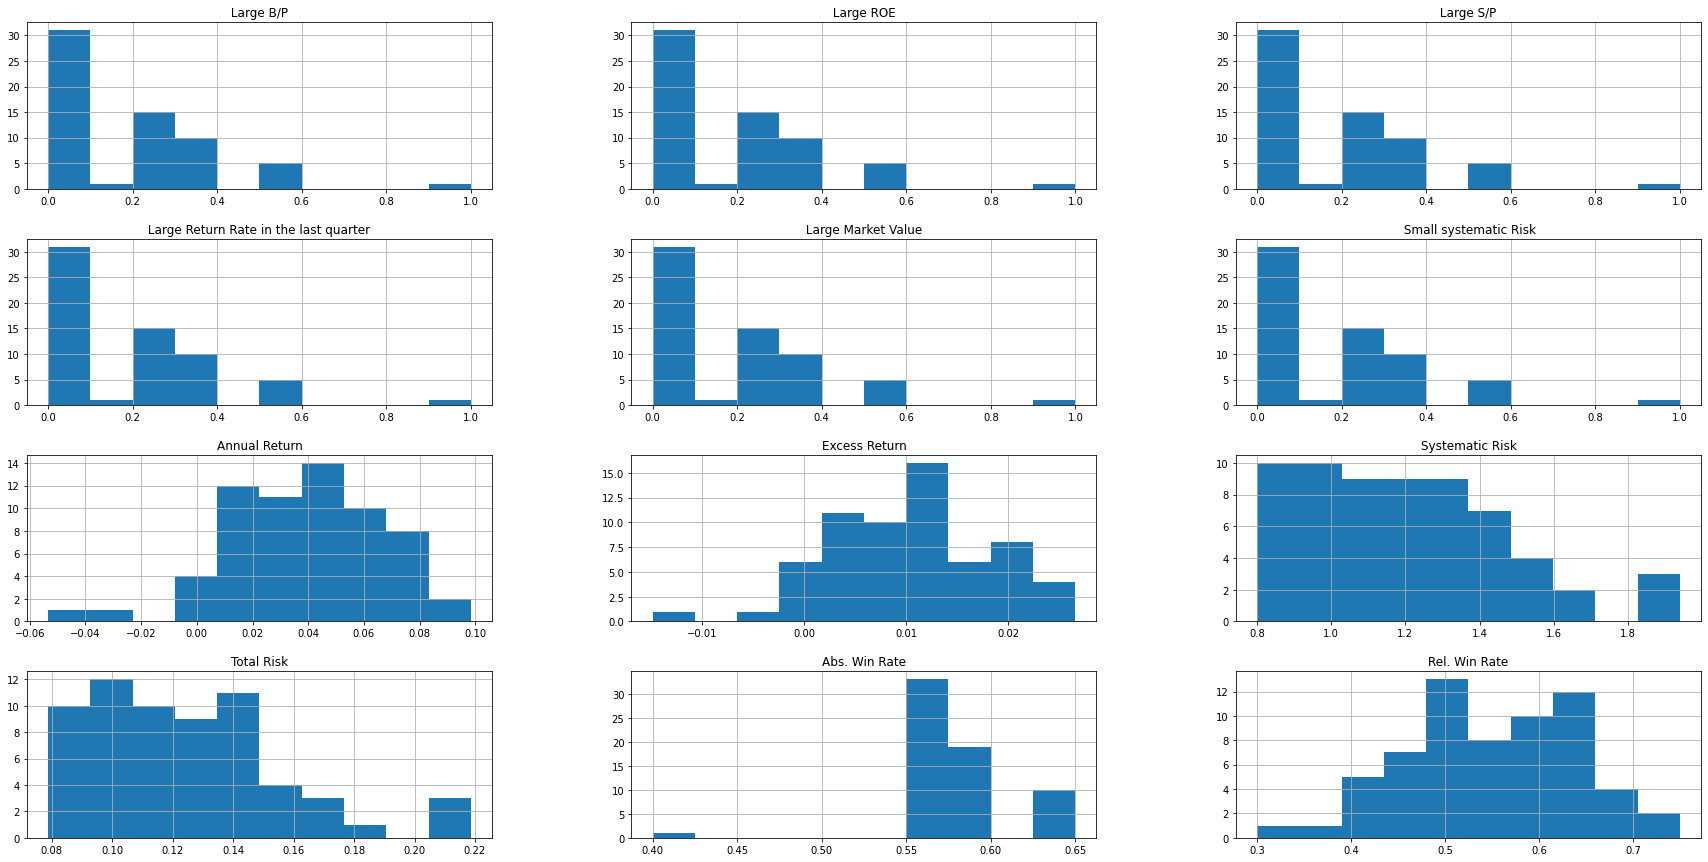

In [28]:
df_4.hist(figsize=(30,15))
plt.plot()

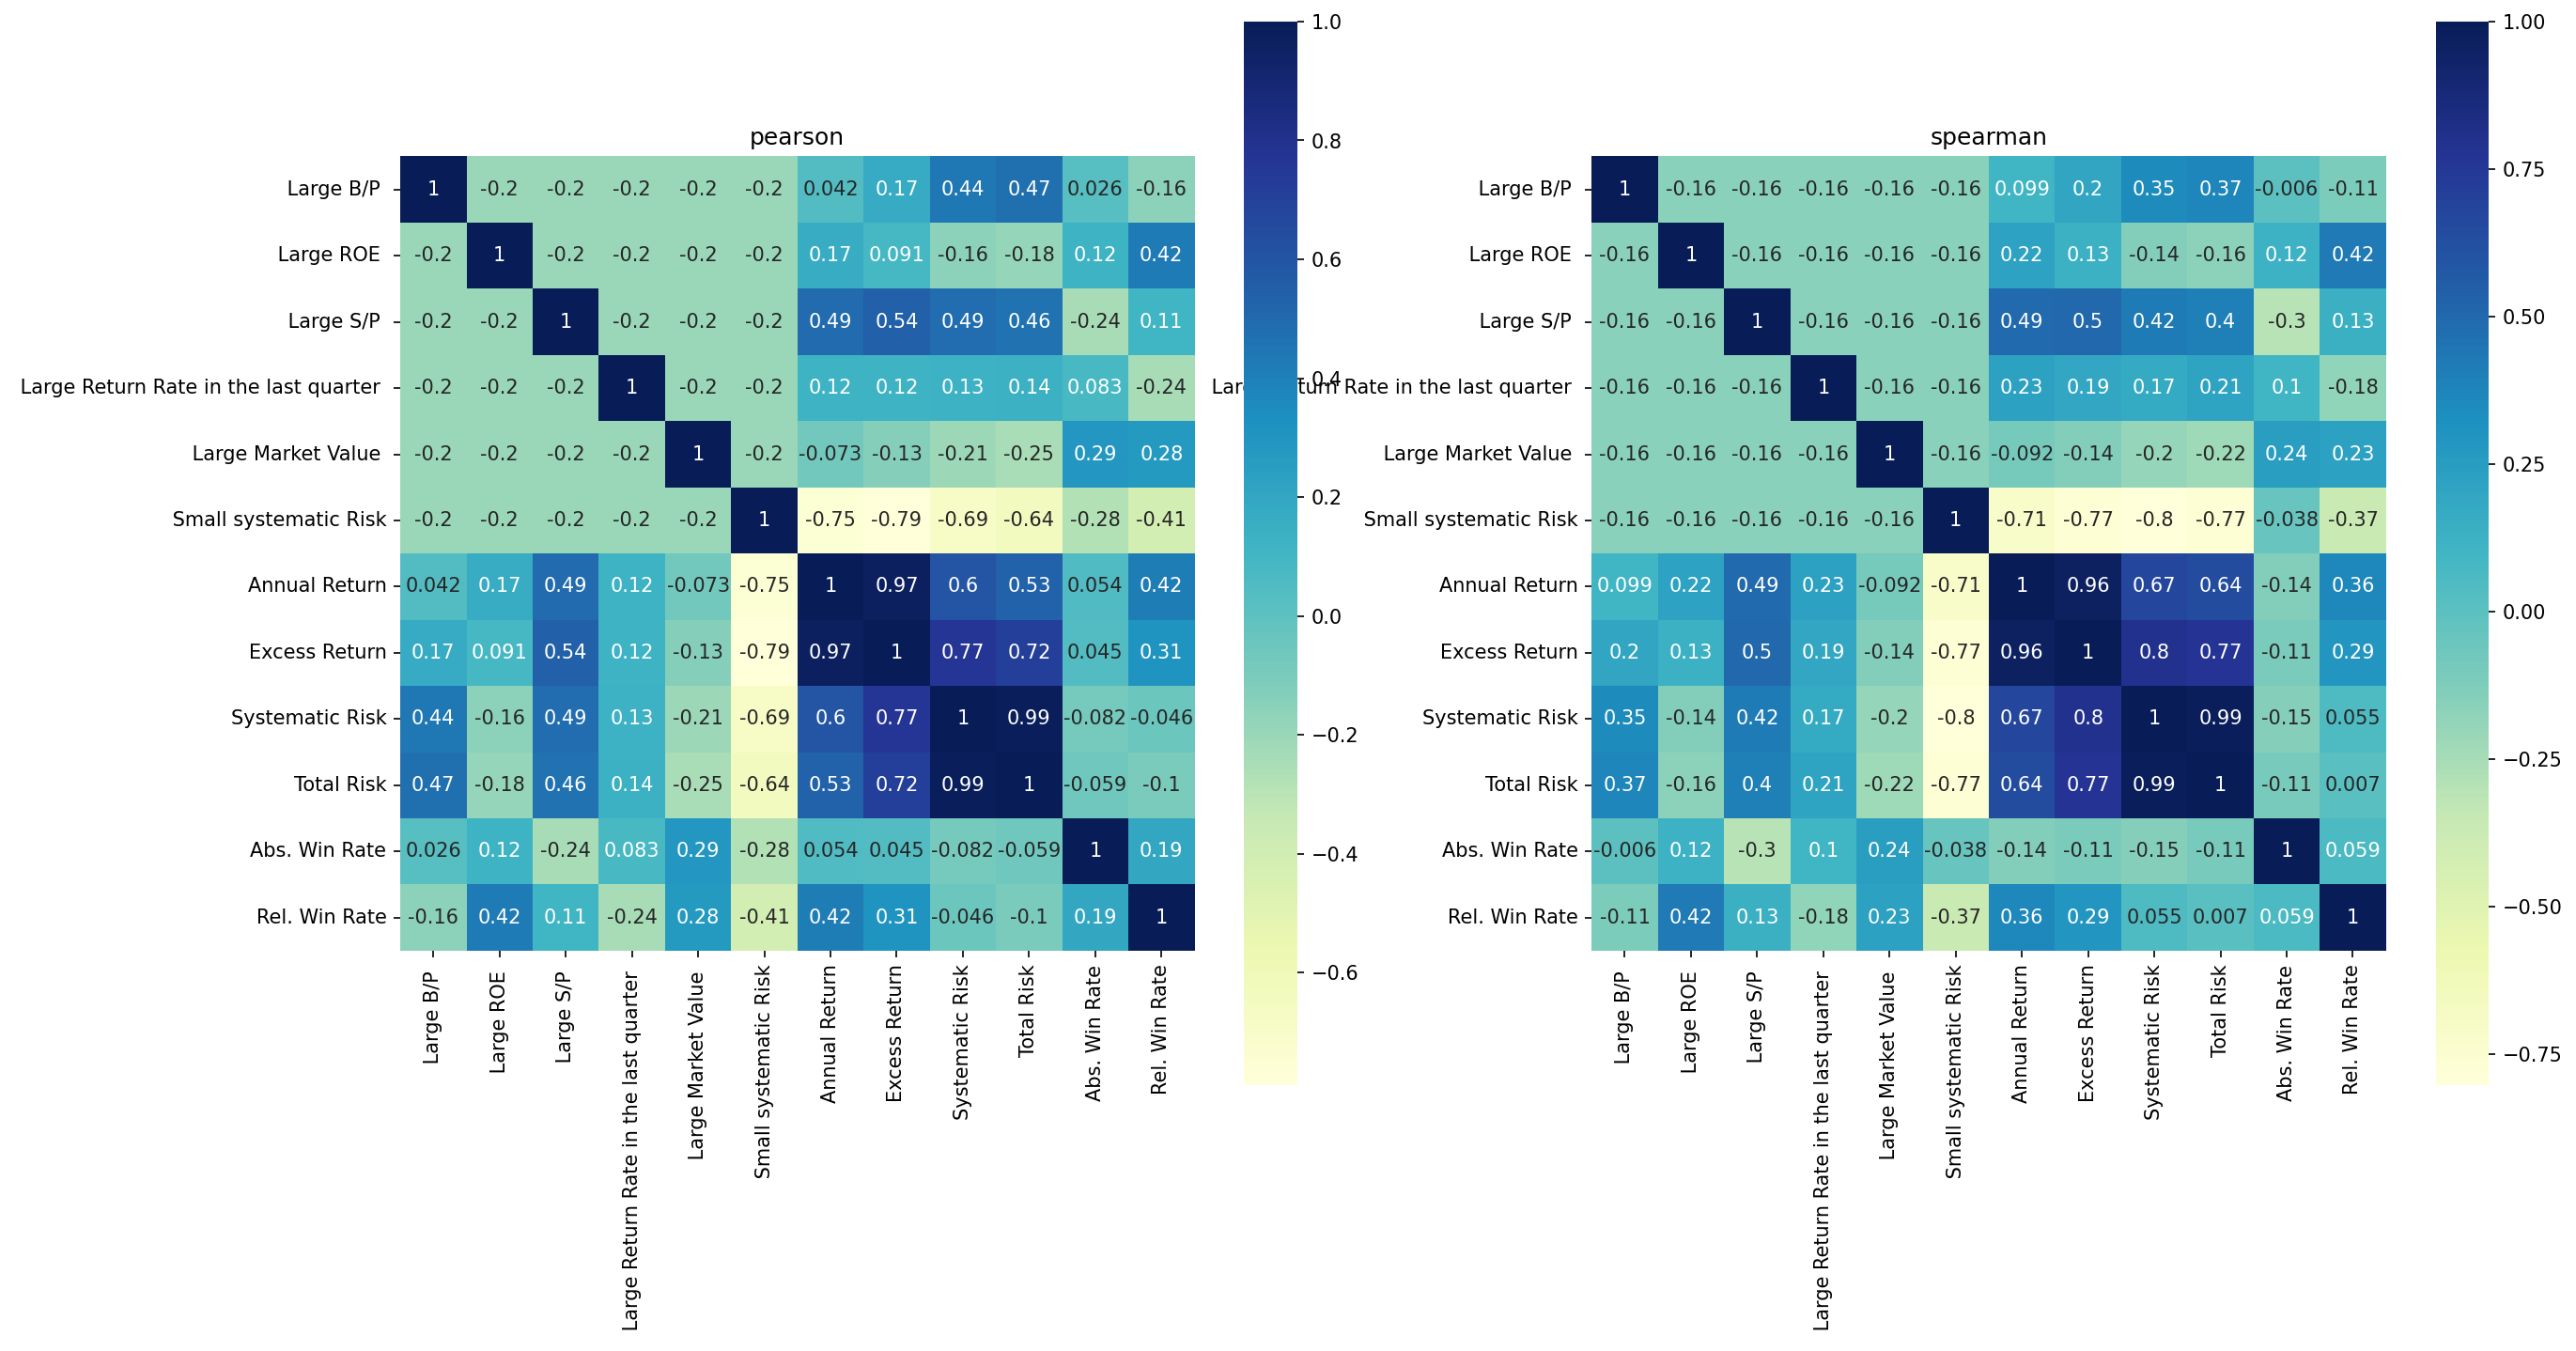

In [29]:
correlation(df_4)

# outlier detection

				ANALYSIS OF:  LARGE B/P  

5 point summary:
      Large B/P 
min       0.0000
25%       0.0000
50%       0.1670
75%       0.2915
max       1.0000
---------------------------------
OUTLIERS in  LARGE B/P  via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
1        1.0  4.215035
---------------------------------
OUTLIERS in  LARGE B/P  via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
1        1.0
---------------------------------


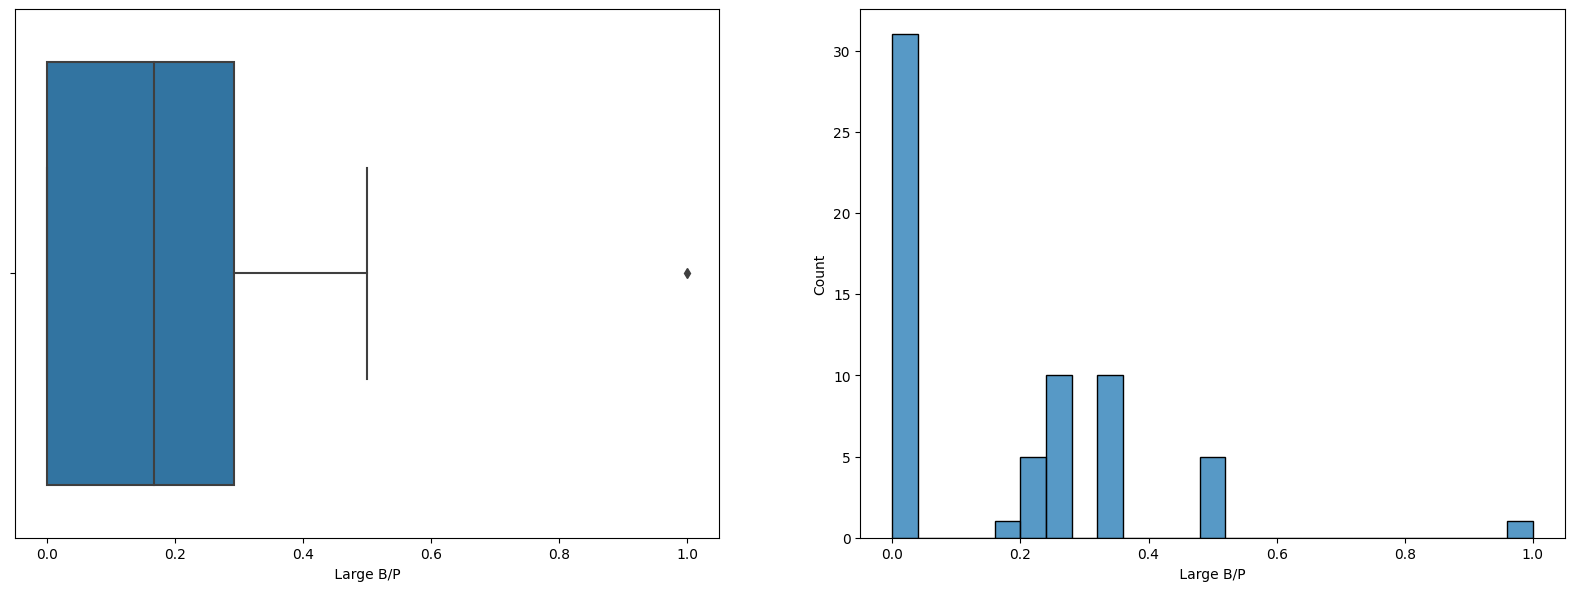

_____________________________________________________________________________________________________________________
				ANALYSIS OF:  LARGE ROE  

5 point summary:
      Large ROE 
min       0.0000
25%       0.0000
50%       0.1670
75%       0.2915
max       1.0000
---------------------------------
OUTLIERS in  LARGE ROE  via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
2        1.0  4.215035
---------------------------------
OUTLIERS in  LARGE ROE  via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
2        1.0
---------------------------------


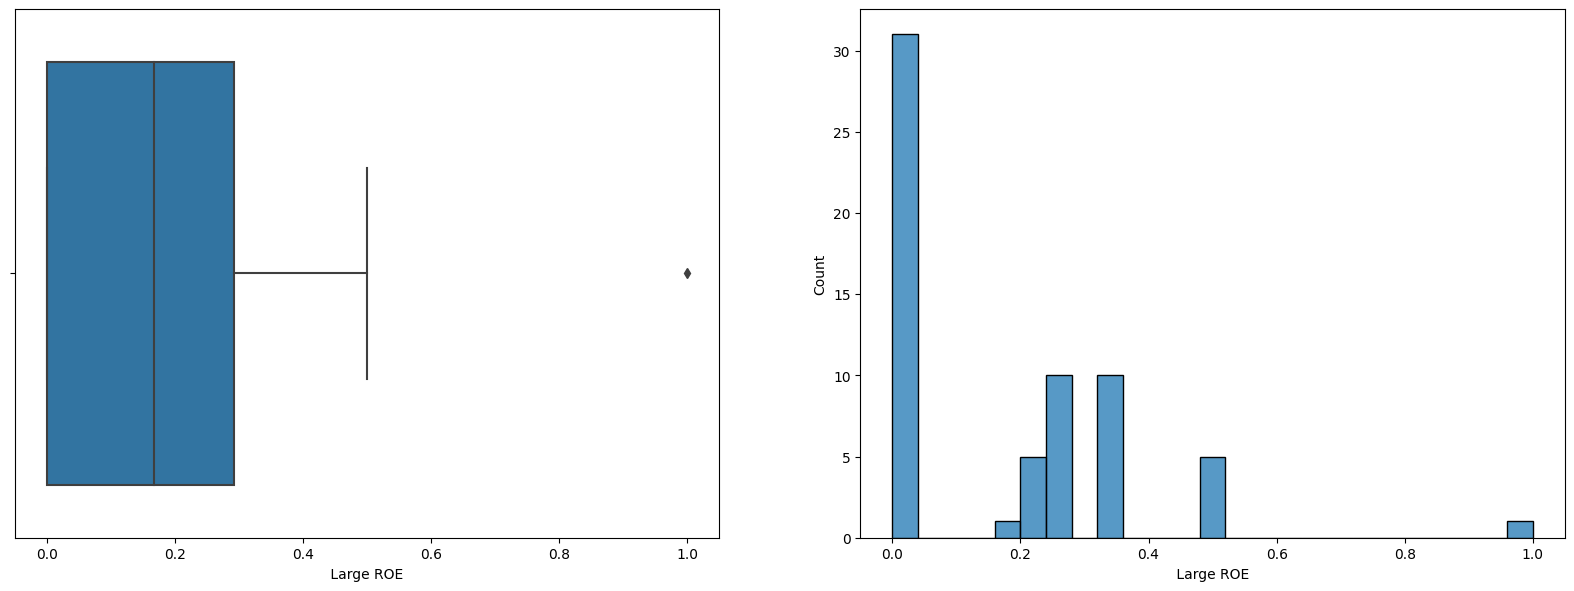

_____________________________________________________________________________________________________________________
				ANALYSIS OF:  LARGE S/P  

5 point summary:
      Large S/P 
min       0.0000
25%       0.0000
50%       0.1670
75%       0.2915
max       1.0000
---------------------------------
OUTLIERS in  LARGE S/P  via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
3        1.0  4.215035
---------------------------------
OUTLIERS in  LARGE S/P  via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
3        1.0
---------------------------------


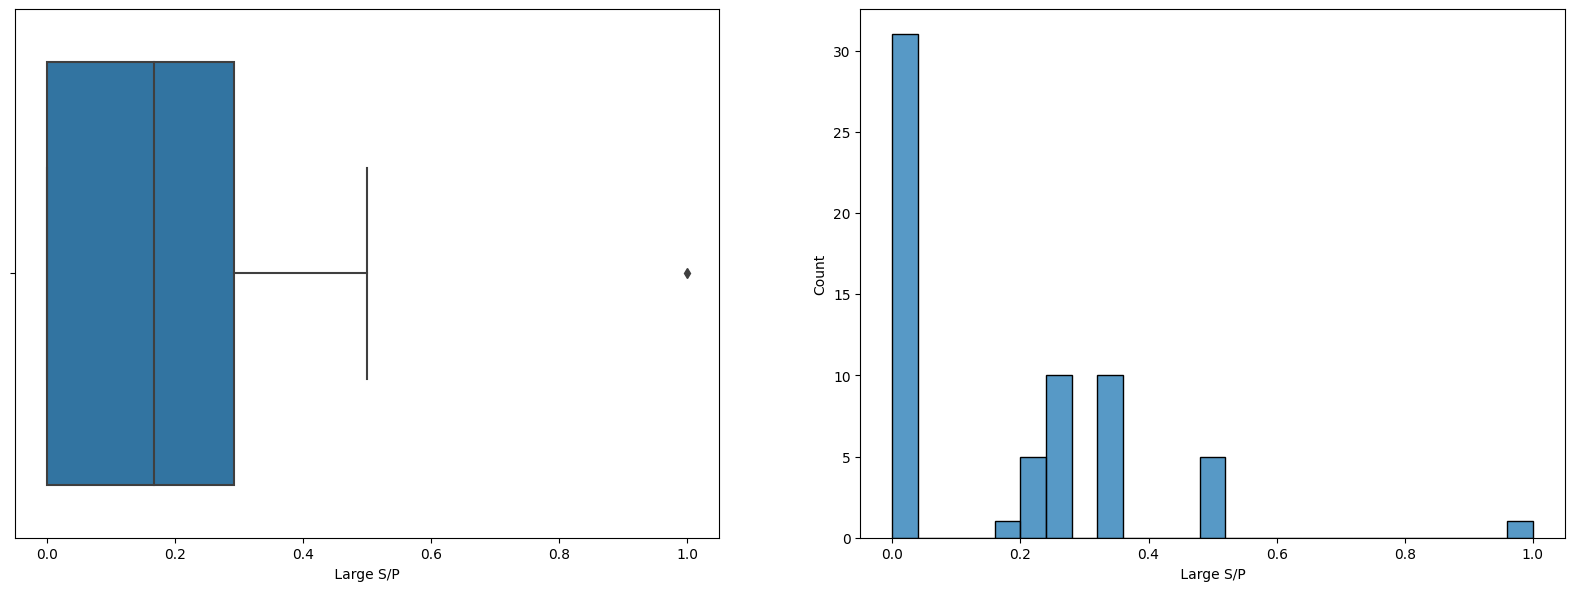

_____________________________________________________________________________________________________________________
				ANALYSIS OF:  LARGE RETURN RATE IN THE LAST QUARTER  

5 point summary:
      Large Return Rate in the last quarter 
min                                   0.0000
25%                                   0.0000
50%                                   0.1670
75%                                   0.2915
max                                   1.0000
---------------------------------
OUTLIERS in  LARGE RETURN RATE IN THE LAST QUARTER  via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
4        1.0  4.215035
---------------------------------
OUTLIERS in  LARGE RETURN RATE IN THE LAST QUARTER  via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
4        1.0
---------------------------------


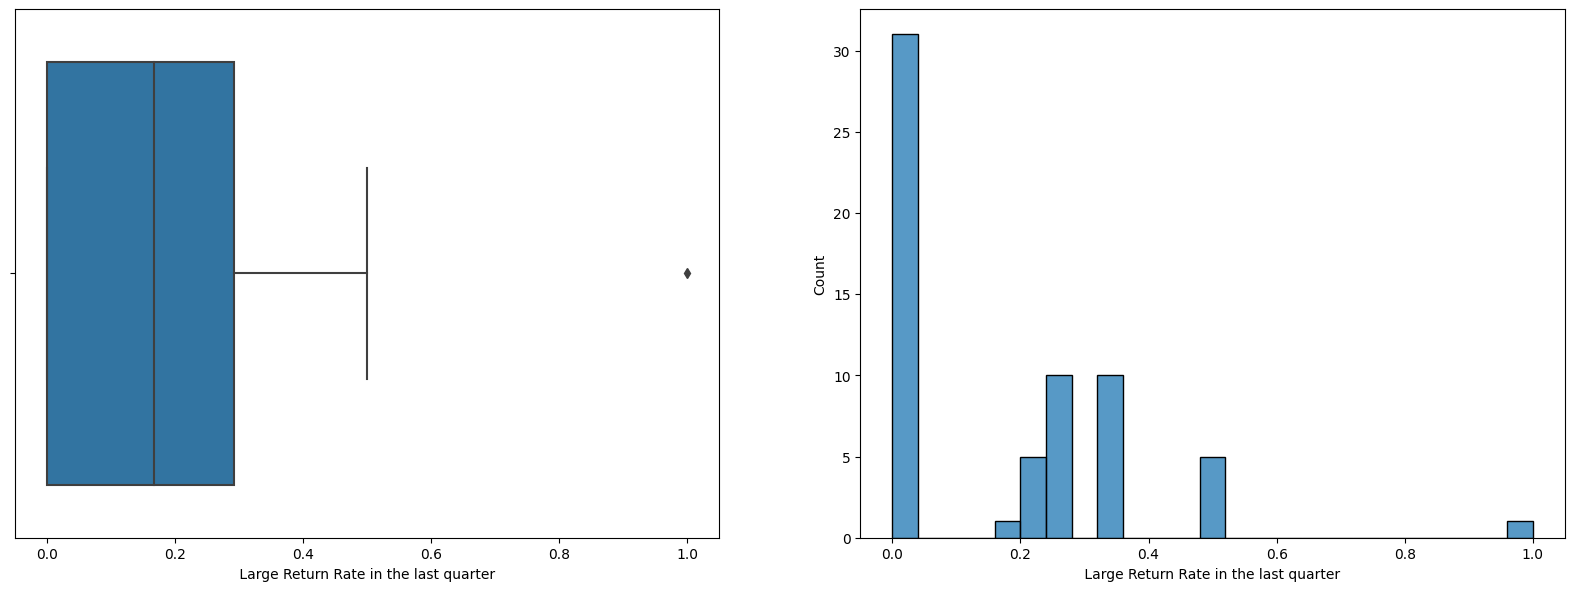

_____________________________________________________________________________________________________________________
				ANALYSIS OF:  LARGE MARKET VALUE  

5 point summary:
      Large Market Value 
min                0.0000
25%                0.0000
50%                0.1670
75%                0.2915
max                1.0000
---------------------------------
OUTLIERS in  LARGE MARKET VALUE  via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
5        1.0  4.215035
---------------------------------
OUTLIERS in  LARGE MARKET VALUE  via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
5        1.0
---------------------------------


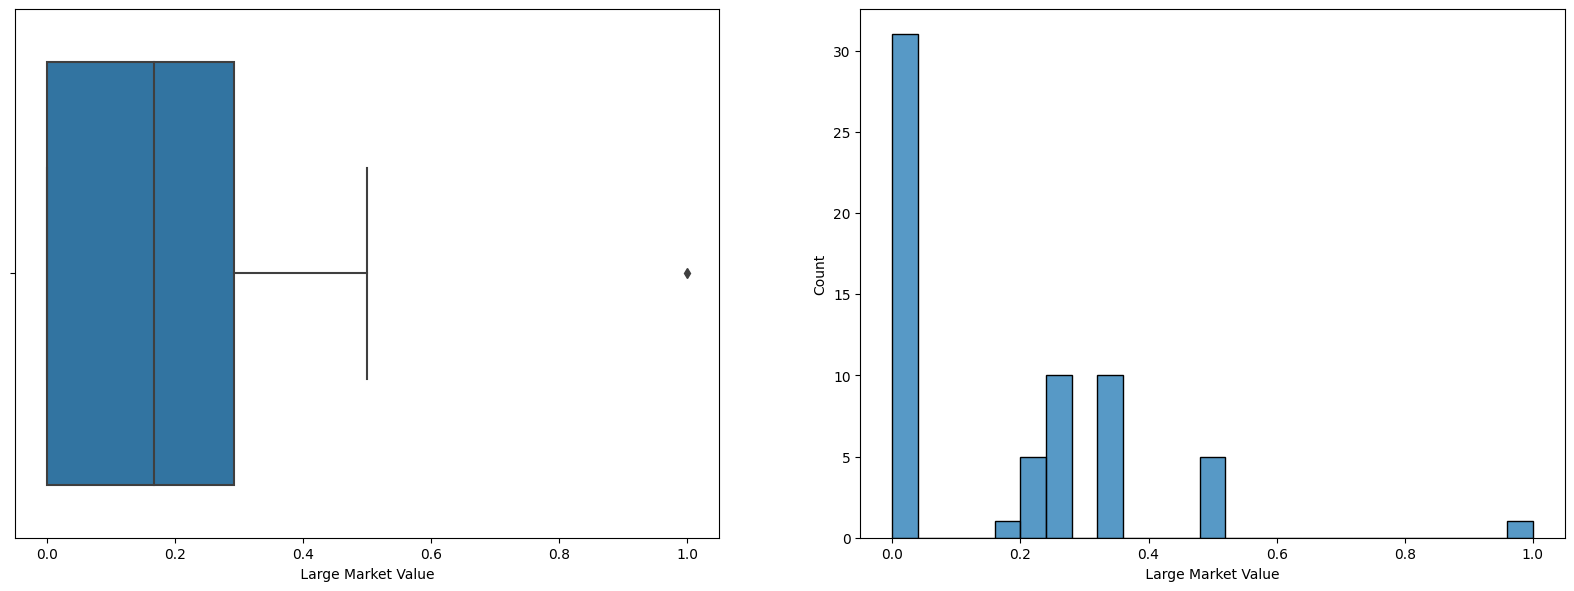

_____________________________________________________________________________________________________________________
				ANALYSIS OF:  SMALL SYSTEMATIC RISK 

5 point summary:
      Small systematic Risk
min                  0.0000
25%                  0.0000
50%                  0.1670
75%                  0.2915
max                  1.0000
---------------------------------
OUTLIERS in  SMALL SYSTEMATIC RISK via Z score

Outlier limits:
lower limit: -0.42652979628137544 
upper limit: 0.7597678915194706

Total outliers: 1
    outliers   Z-score
ID                    
6        1.0  4.215035
---------------------------------
OUTLIERS in  SMALL SYSTEMATIC RISK via IQR

Outlier limits:
lower limit: -0.43724999999999997 
upper limit: 0.72875

Total outliers: 1
    outliers
ID          
6        1.0
---------------------------------


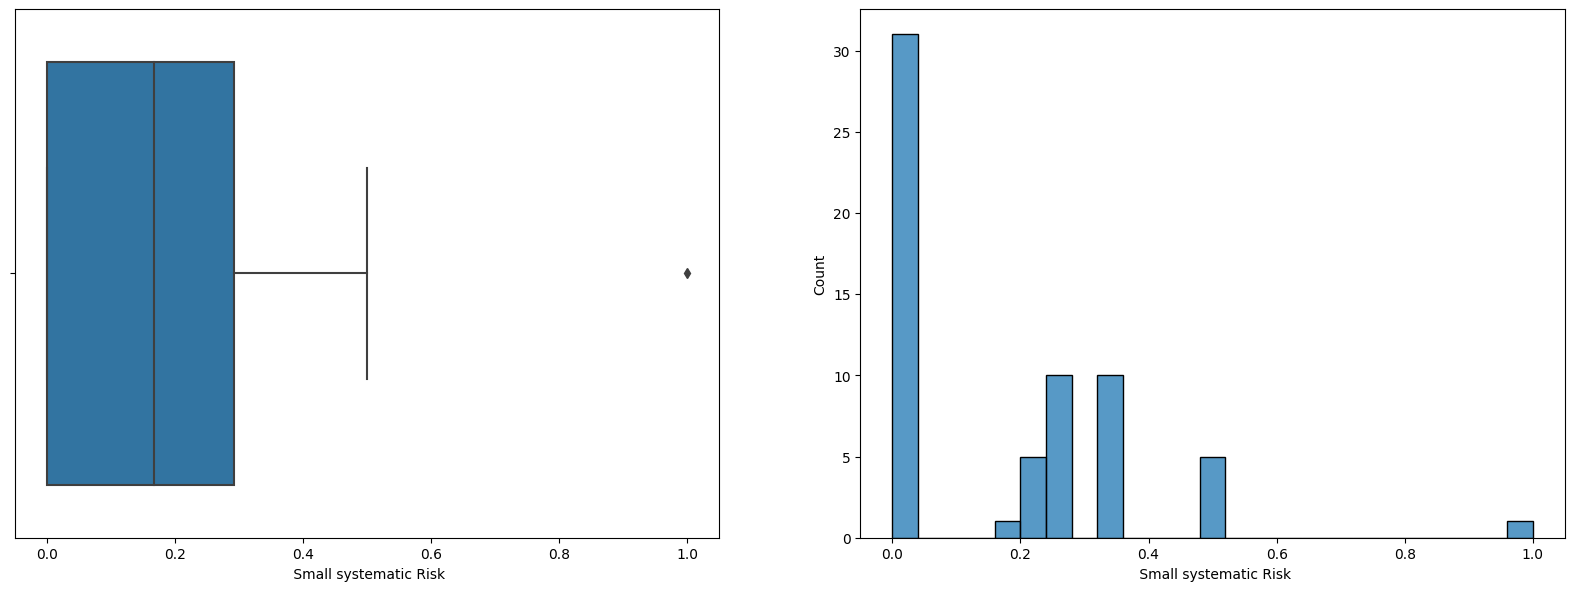

_____________________________________________________________________________________________________________________
				ANALYSIS OF: ANNUAL RETURN 

5 point summary:
     Annual Return
min          0.070
25%          0.138
50%          0.153
75%          0.170
max          0.195
---------------------------------
OUTLIERS in ANNUAL RETURN via Z score

Outlier limits:
lower limit: 0.06628765515364433 
upper limit: 0.23218853532254619

Total outliers: 0
Empty DataFrame
Columns: [outliers, Z-score]
Index: []
---------------------------------
OUTLIERS in ANNUAL RETURN via IQR

Outlier limits:
lower limit: 0.09000000000000001 
upper limit: 0.21800000000000003

Total outliers: 3
    outliers
ID          
6       0.07
16      0.09
41      0.09
---------------------------------


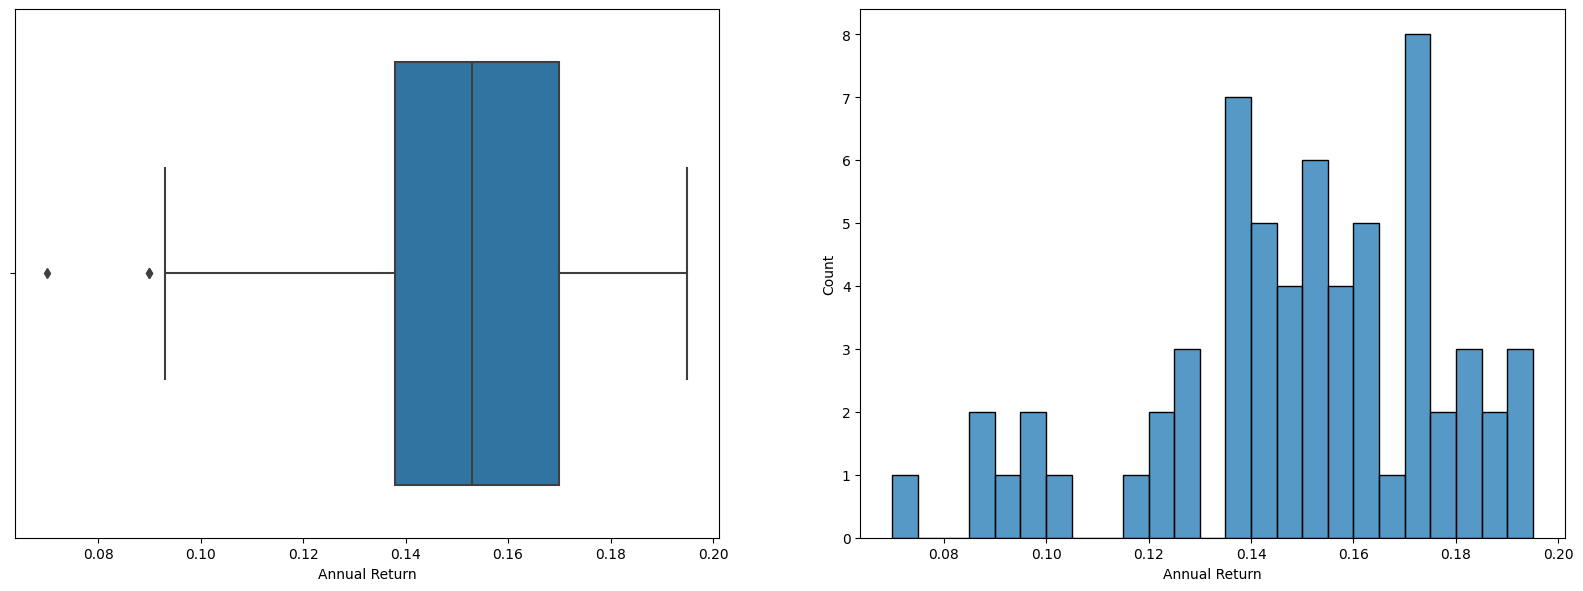

_____________________________________________________________________________________________________________________
				ANALYSIS OF: EXCESS RETURN 

5 point summary:
     Excess Return
min        -0.0050
25%         0.0120
50%         0.0150
75%         0.0195
max         0.0260
---------------------------------
OUTLIERS in EXCESS RETURN via Z score

Outlier limits:
lower limit: -0.006385990359688372 
upper limit: 0.03587805385175187

Total outliers: 0
Empty DataFrame
Columns: [outliers, Z-score]
Index: []
---------------------------------
OUTLIERS in EXCESS RETURN via IQR

Outlier limits:
lower limit: 0.0007500000000000007 
upper limit: 0.03075

Total outliers: 4
    outliers
ID          
4     -0.002
6     -0.005
16    -0.001
41     0.000
---------------------------------


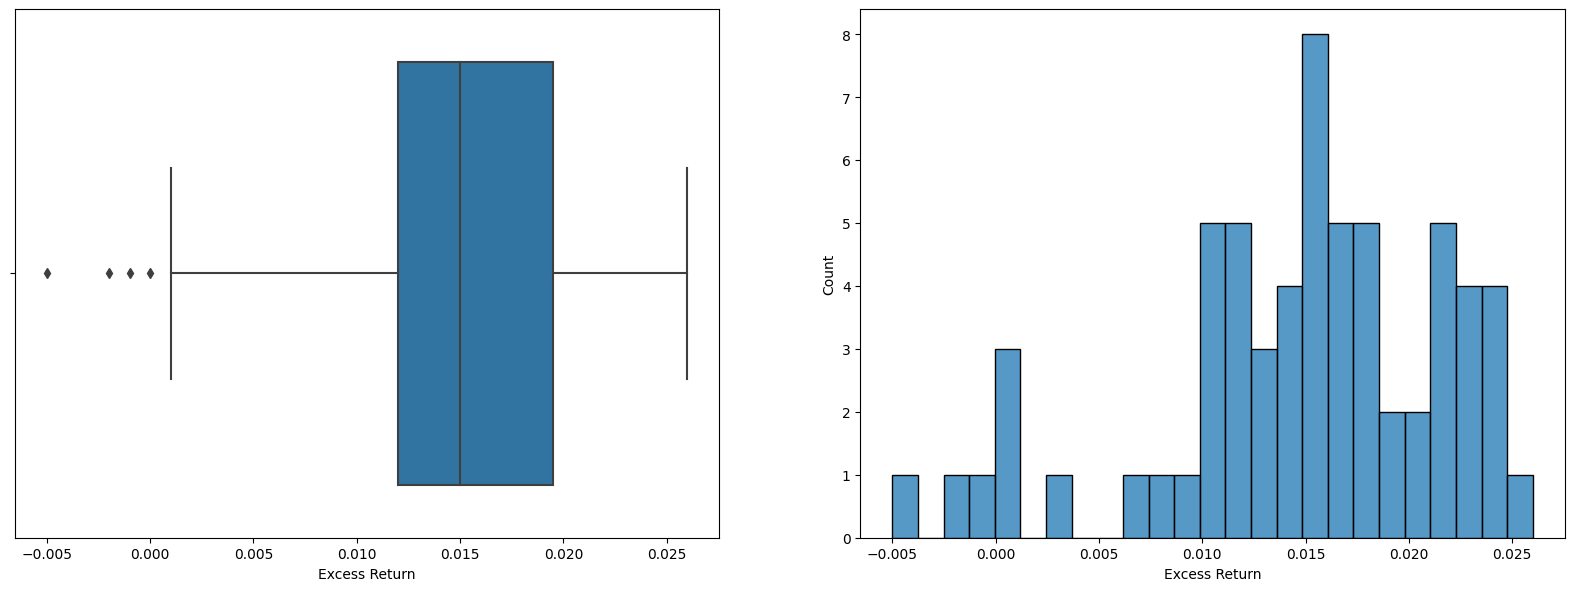

_____________________________________________________________________________________________________________________
				ANALYSIS OF: SYSTEMATIC RISK 

5 point summary:
     Systematic Risk
min             0.82
25%             0.97
50%             1.01
75%             1.08
max             1.39
---------------------------------
OUTLIERS in SYSTEMATIC RISK via Z score

Outlier limits:
lower limit: 0.7020366607255565 
upper limit: 1.369709371020475

Total outliers: 1
    outliers  Z-score
ID                   
4       1.39  3.18234
---------------------------------
OUTLIERS in SYSTEMATIC RISK via IQR

Outlier limits:
lower limit: 0.8049999999999998 
upper limit: 1.245

Total outliers: 4
    outliers
ID          
1       1.33
3       1.30
4       1.39
8       1.32
---------------------------------


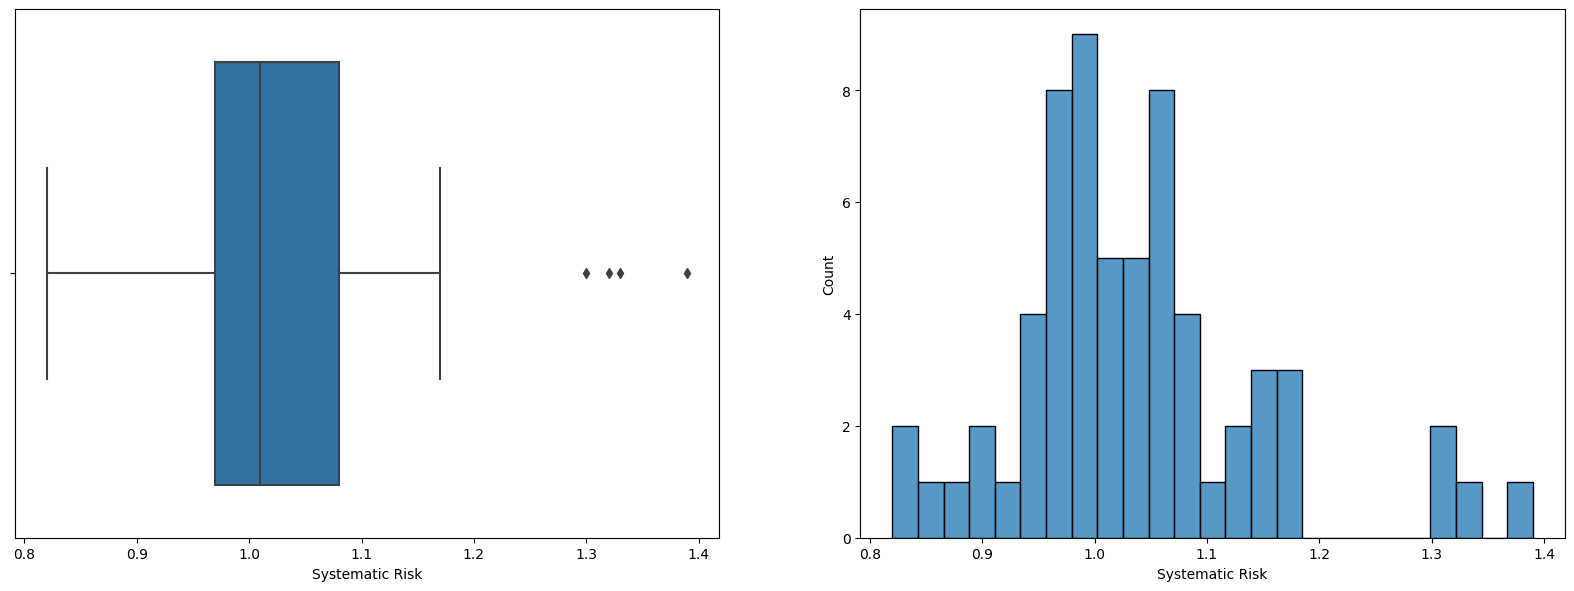

_____________________________________________________________________________________________________________________
				ANALYSIS OF: TOTAL RISK 

5 point summary:
     Total Risk
min      0.0860
25%      0.0965
50%      0.1040
75%      0.1130
max      0.1490
---------------------------------
OUTLIERS in TOTAL RISK via Z score

Outlier limits:
lower limit: 0.06382771232094642 
upper limit: 0.1488072083139742

Total outliers: 2
    outliers   Z-score
ID                    
1      0.149  3.013612
8      0.149  3.013612
---------------------------------
OUTLIERS in TOTAL RISK via IQR

Outlier limits:
lower limit: 0.07175000000000001 
upper limit: 0.13775

Total outliers: 4
    outliers
ID          
1      0.149
3      0.144
4      0.144
8      0.149
---------------------------------


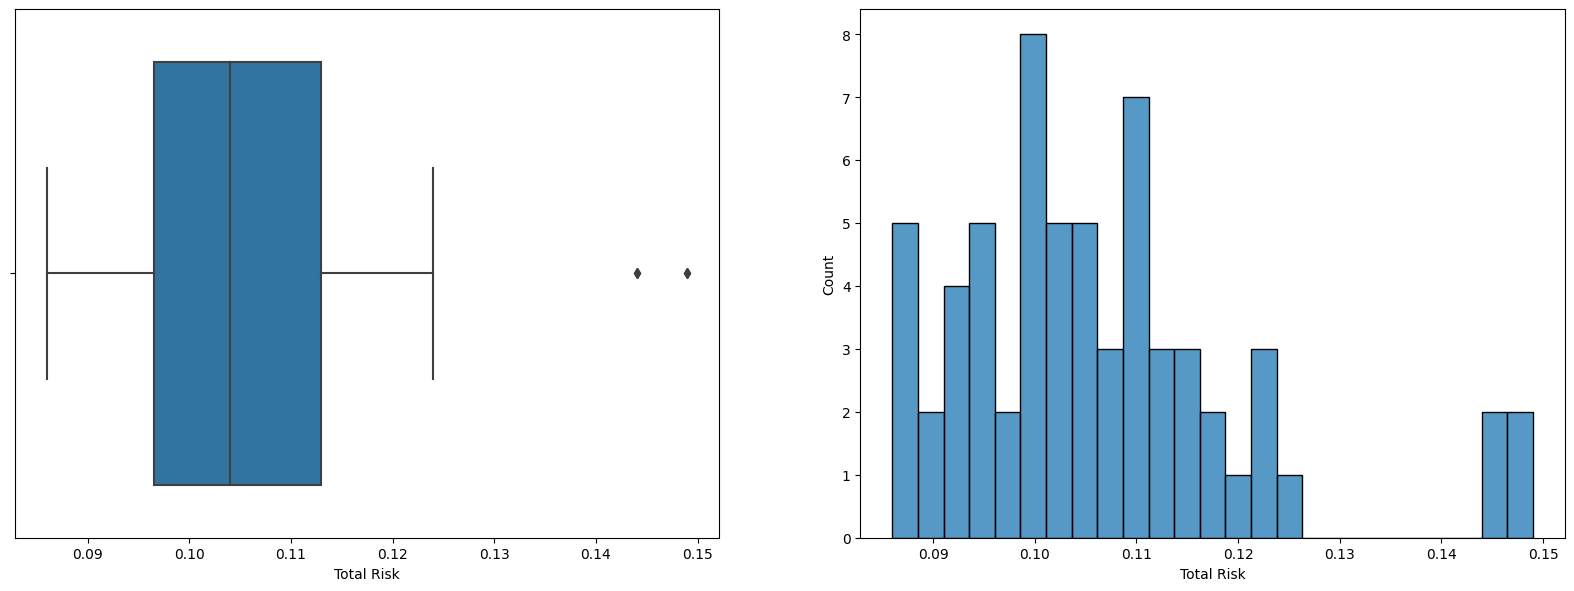

_____________________________________________________________________________________________________________________
				ANALYSIS OF: ABS. WIN RATE 

5 point summary:
     Abs. Win Rate
min          0.563
25%          0.663
50%          0.675
75%          0.700
max          0.750
---------------------------------
OUTLIERS in ABS. WIN RATE via Z score

Outlier limits:
lower limit: 0.5726515020337277 
upper limit: 0.7821421487599232

Total outliers: 1
    outliers   Z-score
ID                    
6      0.563 -3.276428
---------------------------------
OUTLIERS in ABS. WIN RATE via IQR

Outlier limits:
lower limit: 0.6075000000000002 
upper limit: 0.7554999999999998

Total outliers: 2
    outliers
ID          
6      0.563
41     0.588
---------------------------------


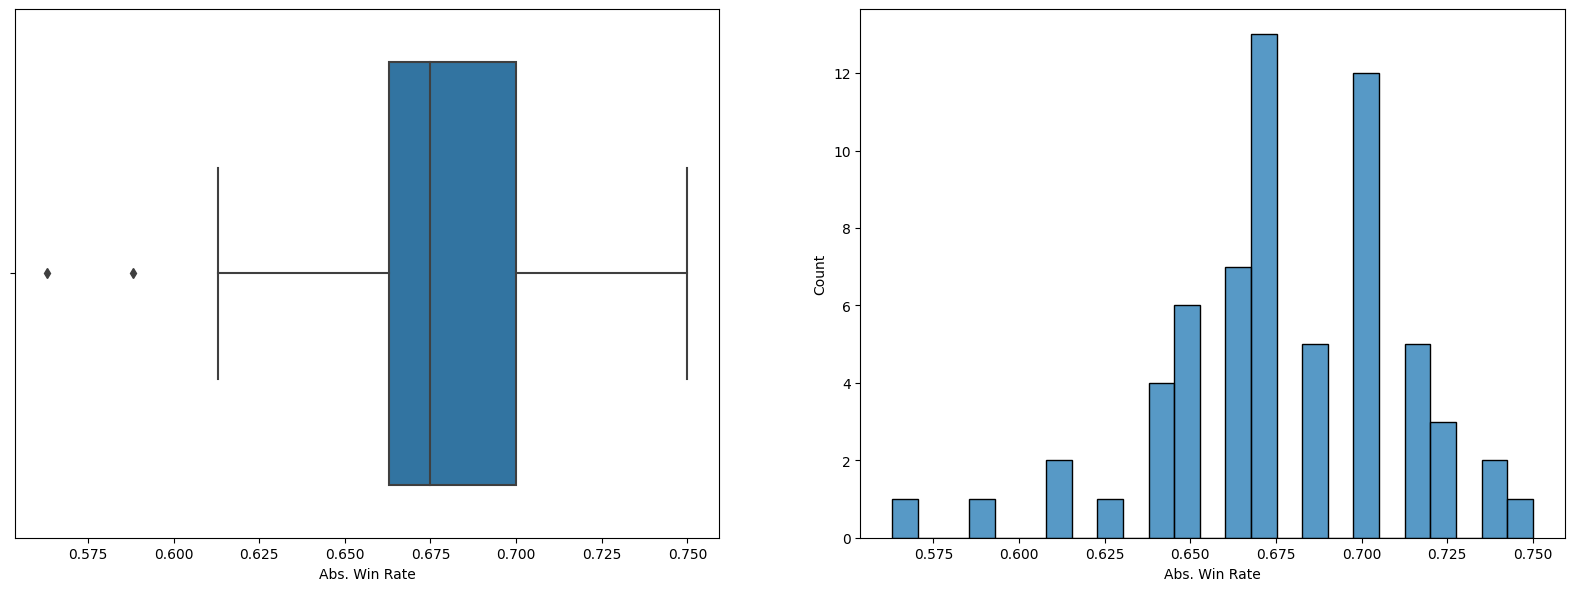

_____________________________________________________________________________________________________________________
				ANALYSIS OF: REL. WIN RATE 

5 point summary:
     Rel. Win Rate
min          0.450
25%          0.525
50%          0.575
75%          0.625
max          0.663
---------------------------------
OUTLIERS in REL. WIN RATE via Z score

Outlier limits:
lower limit: 0.4053236167867919 
upper limit: 0.7415970181338427

Total outliers: 0
Empty DataFrame
Columns: [outliers, Z-score]
Index: []
---------------------------------
OUTLIERS in REL. WIN RATE via IQR

Outlier limits:
lower limit: 0.37500000000000006 
upper limit: 0.7749999999999999

Total outliers: 0
Empty DataFrame
Columns: [outliers]
Index: []
---------------------------------


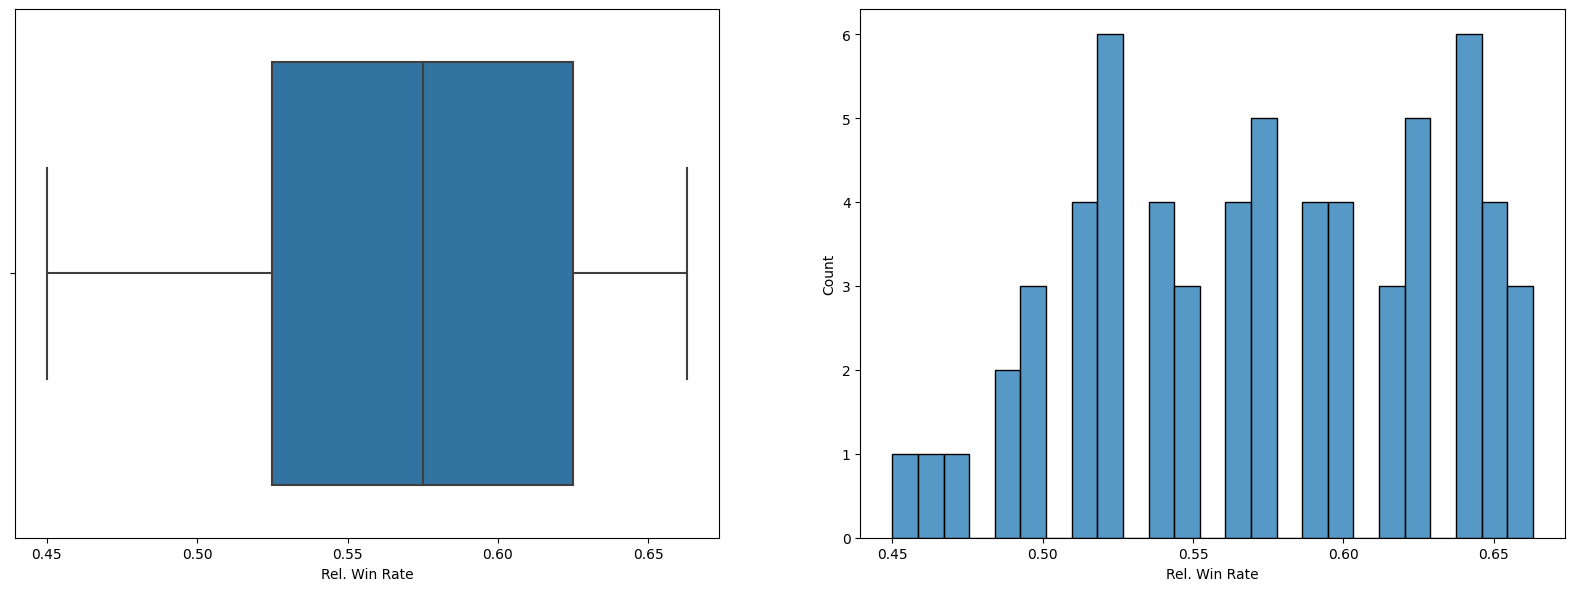

_____________________________________________________________________________________________________________________


In [30]:
for col in df_all.columns:
    analysis_quant(df_all[col])

# BIVARIATE ANALYSIS

### analysing continuous features  

In [31]:
from sklearn.preprocessing import KBinsDiscretizer
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')

df_=df_all.drop('Annual Return', axis=1)
num_binned=pd.DataFrame(discrete.fit_transform(df_), index=df_.index, columns=df_.columns)
num_binned.head()

C:\Users\afzal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\afzal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\afzal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\afzal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider 

,Large B/P,Large ROE,Large S/P,Large Return Rate in the last quarter,Large Market Value,Small systematic Risk,Excess Return,Systematic Risk,Total Risk,Abs. Win Rate,Rel. Win Rate
ID,,,,,,,,,,,
1,3.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,9.0,3.0,2.0
2,0.0,3.0,0.0,0.0,0.0,0.0,1.0,9.0,6.0,3.0,9.0
3,0.0,0.0,3.0,0.0,0.0,0.0,7.0,9.0,9.0,1.0,1.0
4,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,7.0,3.0


In [1]:
X_bin_combined=pd.concat([df_all['Annual Return'],num_binned],axis=1,join='inner')

for col in df_all.columns:
    plt.figure(figsize=(20,5), dpi=100)
    sns.barplot(x=col, y='Annual Return',data=X_bin_combined, estimator=np.mean )
    plt.show()

NameError: name 'pd' is not defined

# dropping certain columns

# MODEL

### train test split

In [57]:
X=df_all.iloc[:,:6]
y=df_all['Annual Return']
xtrain,xtest,ytrain,ytest=train_test_split(X,y)

### defining models

In [58]:
model_lr=LinearRegression(n_jobs=-1)

model_dt=DecisionTreeRegressor() #max_depth=30, min_samples_split=50 )   

model_rf=RandomForestRegressor(n_jobs=-1) #, max_features=0.5, max_depth=6, min_samples_split=50)    

model_ada_dt=AdaBoostRegressor( )#base_estimator=DecisionTreeRegressor(max_depth=6, min_samples_split=50), n_estimators=100, learning_rate=5)   

model_ada_rf=AdaBoostRegressor(base_estimator=RandomForestRegressor(n_jobs=-1)) #, max_features=0.5, max_depth=6, min_samples_split=50), n_estimators=50, learning_rate=0.1)  

model_gb=GradientBoostingRegressor() #max_depth=6, min_samples_split=50)

model_xgb=XGBRegressor(n_jobs=-1) #n_estimators=500, learning_rate=0.1 ) 

model_svr=SVR() #C=0.1, degree=5 )   

model_knc=KNeighborsRegressor(n_neighbors=5, n_jobs=-1, weights='distance')   

model_rnc=RadiusNeighborsRegressor(radius=10, n_jobs=-1, weights='distance')   

# dictionary of all models
models={'linear':model_lr, 'decision tree':model_dt, 'random forest':model_rf, 'adaboost using dt':model_ada_dt, 'adaboost using rf':model_ada_rf,
        'gradboost':model_gb, 'xgboost':model_xgb, 'SVR':model_svr, 'KNC':model_knc, 'RNC':model_rnc }

### pipeline and scores

In [59]:
# making 
pipelines=[]
r2={}

for name,model in models.items():
    
    # making pipeline for each model
    pipeline = Pipeline(steps=[( "scaler", StandardScaler() ),
                               ( "regressor", model )
                              ]
                       )
    
    # print name of pipeline
    print(name.upper())
    
    # fitting data
    pipeline.fit(xtrain,ytrain)
    
    # calculating scores and storing
    score_cv=np.mean(cross_val_score(pipeline, X, y, cv=5, scoring='r2'))    
    r2[name]=score_cv
    
    # printing scores
    print('train score: ', pipeline.score(xtrain,ytrain) )
    print('test score: ', pipeline.score(xtest,ytest) )
    print('cross validation r2 score:', score_cv)
    print()
    

LINEAR
train score:  0.631169651344994
test score:  0.5677173539427112
cross validation r2 score: 0.06909578808654171

DECISION TREE
train score:  1.0
test score:  0.8413491182636575
cross validation r2 score: 0.6463143206054653

RANDOM FOREST
train score:  0.9580209658296263
test score:  0.6359132198791457
cross validation r2 score: 0.7296241607947105

ADABOOST USING DT
train score:  0.9388326741267586
test score:  0.5937814776024992
cross validation r2 score: 0.7292813179829821

ADABOOST USING RF
train score:  0.9820251742040604
test score:  0.6806466087063744
cross validation r2 score: 0.7694034645997091

GRADBOOST
train score:  0.9970808508561939
test score:  0.8028138199971361
cross validation r2 score: 0.8357381766927003

XGBOOST
train score:  0.9990600616571099
test score:  0.8302611685745098
cross validation r2 score: 0.806237277413608

SVR
train score:  -0.1683136827123073
test score:  -0.002219755826859071
cross validation r2 score: -0.8887749054042123

KNC
train score:  1.0


### model scores comparison

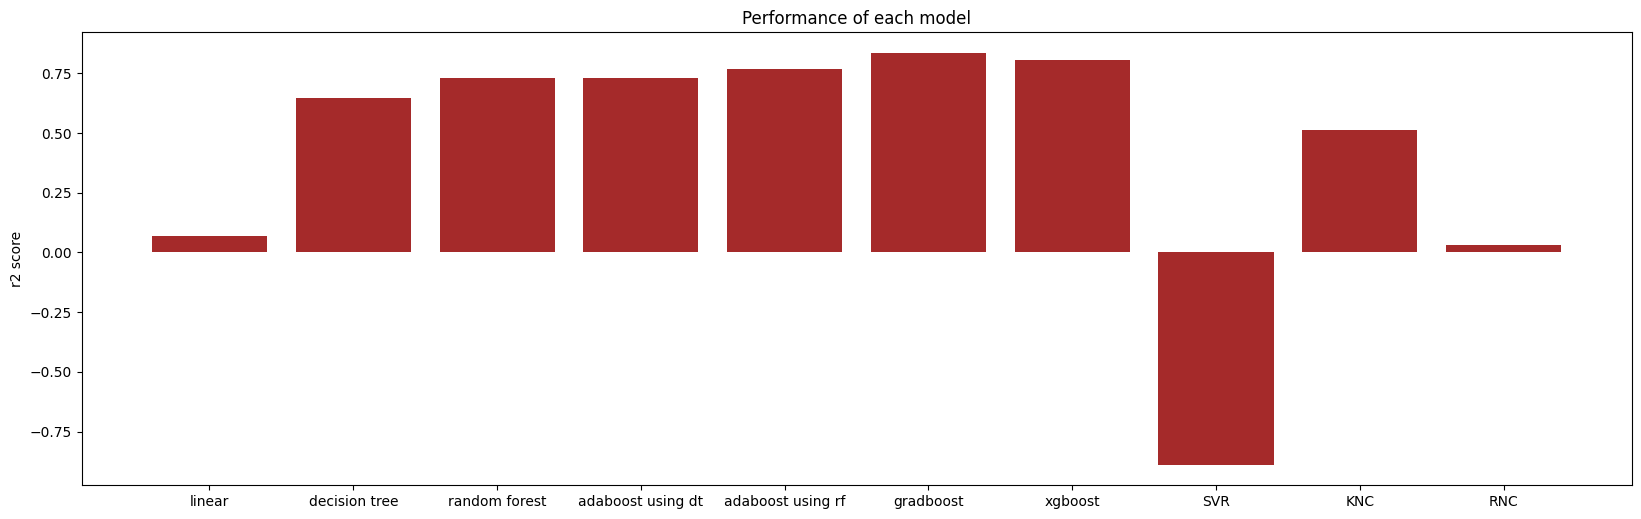

In [60]:
plt.figure(figsize=(20,6), dpi=100)
plt.bar( r2.keys(),r2.values(), color='brown', )
plt.ylabel('r2 score')
plt.title('Performance of each model')
plt.show()